# JAX GPU Test

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp

jnp.array(1.)
print("Available devices:", jax.devices())

Available devices: [CudaDevice(id=0)]


# Load Dataset

In [2]:
import dataset_util

tokenized_examples, labels, vocabulary, inverse_vocabulary = dataset_util.main(max_length=25,
                                                                  seed=0,
                                                                  root_dir="KGDatasets/Kinship",
                                                                  split="train")
tokenized_examples, labels

Sample of generated dataset:
Example 1: 1 4 39 5 25 6 94 3 0 0...
         (Original: [CLS] Is person65 the term8 of person8 ? | Label: 1)
Example 2: 1 4 109 5 20 6 60 3 0 0...
         (Original: [CLS] Is person20 the term20 of person21 ? | Label: 1)
Example 3: 1 4 69 5 25 6 76 3 0 0...
         (Original: [CLS] Is person41 the term8 of person15 ? | Label: 0)
Example 4: 1 4 65 5 17 6 41 3 0 0...
         (Original: [CLS] Is person24 the term4 of person11 ? | Label: 1)
Example 5: 1 4 63 5 100 6 89 3 0 0...
         (Original: [CLS] Is person67 the term22 of person27 ? | Label: 0)

Dataset statistics:
Total examples: 17088
Positive examples: 8544 (50.00%)
Negative examples: 8544 (50.00%)
Vocabulary size: 136


(array([[  1,   4,  39, ...,   0,   0,   0],
        [  1,   4, 109, ...,   0,   0,   0],
        [  1,   4,  69, ...,   0,   0,   0],
        ...,
        [  1,   4,  68, ...,   0,   0,   0],
        [  1,   4, 110, ...,   0,   0,   0],
        [  1,   4,  19, ...,   0,   0,   0]],
       shape=(17088, 25), dtype=int32),
 array([1, 1, 0, ..., 0, 0, 1], shape=(17088,), dtype=int32))

In [3]:
from sklearn.model_selection import train_test_split

#   tokenized_examples: ndarray, shape=(17088, 25)
#   labels:               ndarray, shape=(17088,)
seed = 0

# 1) First split off 20% of data for (val+test), keeping class balance
X_temp, X_test, y_temp, y_test = train_test_split(
    tokenized_examples,      # all examples
    labels,                  # all labels
    test_size=0.20,          # 20% -> this will be further split to 10% val, 10% test
    random_state=seed,       # for reproducibility
    stratify=labels          # preserve label ratio
)

# 2) From the remaining 80% (X_temp, y_temp), split off 12.5% of *that* as validation
#    12.5% of 80% = 0.10 of the original full set
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,         # 12.5% of X_temp -> 10% of original full
    random_state=seed,
    stratify=y_temp
)

# Now you have:
#   X_train: (0.80 * 17088 ≃ 13670, 25)
#   y_train: (13670,)
#   X_val:   (0.10 * 17088 ≃ 1709, 25)
#   y_val:   (1709,)
#   X_test:  (0.10 * 17088 ≃ 1709, 25)
#   y_test:  (1709,)

print("train:",  X_train.shape, y_train.shape)
print("val:  ",  X_val.shape,   y_val.shape)
print("test: ",  X_test.shape,  y_test.shape)

train: (11961, 25) (11961,)
val:   (1709, 25) (1709,)
test:  (3418, 25) (3418,)


# Quaternionic MLP + Riemannian Adam

In [4]:
import jax.random as jr
import jax
import jax.numpy as jnp
import equinox as eqx
from typing import List, Optional

def hamilton_prod(a: jnp.ndarray, b: jnp.ndarray) -> jnp.ndarray:
    """
    Compute the Hamilton product of two quaternions a and b,
    each represented as a 1D array of shape (4,).
    """
    ar, ai, aj, ak = a[0], a[1], a[2], a[3]
    br, bi, bj, bk = b[0], b[1], b[2], b[3]

    r = ar * br - ai * bi - aj * bj - ak * bk
    i = ar * bi + ai * br + aj * bk - ak * bj
    j = ar * bj - ai * bk + aj * br + ak * bi
    k = ar * bk + ai * bj - aj * bi + ak * br

    return jnp.array([r, i, j, k])


def quaternion_exp(q: jnp.ndarray) -> jnp.ndarray:
    """
    Slice-regular quaternionic exponential on array (..., 4).
    """
    # Split scalar and vector part
    r = q[..., 0]              # shape (...,)
    v = q[..., 1:]             # shape (..., 3)

    # Magnitude of vector part
    norm_v = jnp.linalg.norm(v, axis=-1, keepdims=True)  # (..., 1)

    # Compute exp(a) * (cos||v||, sin||v|| * v/||v||)
    exp_r = jnp.exp(r)[..., None]  # (..., 1)
    cos_t = jnp.cos(norm_v)         # (..., 1)
    sin_t = jnp.sin(norm_v)         # (..., 1)

    # Unit vector of v, safely
    v_unit = jnp.where(norm_v > 1e-7, v / norm_v, 0.0)  # (..., 3)

    # Combine
    real_part   = exp_r * cos_t            # (..., 1)
    vector_part = exp_r * sin_t * v_unit   # (..., 3)

    return jnp.concatenate([real_part, vector_part], axis=-1)


def quaternion_log(q: jnp.ndarray) -> jnp.ndarray:
    """
    Slice-regular quaternionic logarithm on array (..., 4).
    """
    # Norm of quaternion
    norm_q = jnp.linalg.norm(q, axis=-1, keepdims=True)  # (..., 1)

    # Scalar and vector parts
    r = q[..., 0:1]       # (..., 1)
    v = q[..., 1:]        # (..., 3)

    # Log of norm
    ln_norm = jnp.log(norm_q)  # (..., 1)

    # Angle for vector direction
    ratio = jnp.clip(r / norm_q, -1 + 1e-6, 1 - 1e-6)  # (..., 1)
    theta = jnp.arccos(ratio)                         # (..., 1)

    # Unit vector of v
    norm_v = jnp.linalg.norm(v, axis=-1, keepdims=True)  # (..., 1)
    v_unit = jnp.where(norm_v > 1e-7, v / norm_v, 0.0)    # (..., 3)

    vector_part = theta * v_unit  # (..., 3)

    return jnp.concatenate([ln_norm, vector_part], axis=-1)


def quaternion_softplus(q: jnp.ndarray) -> jnp.ndarray:
    """
    Slice-regular softplus: f(q) = log(1 + exp(q)).
    """
    one = jnp.array([1.0, 0.0, 0.0, 0.0])
    exp_q = quaternion_exp(q)
    return quaternion_log(one + exp_q)


class QuaternionLinear(eqx.Module):
    weight: jnp.ndarray       # shape (out, in, 4)
    bias: Optional[jnp.ndarray]  # shape (out, 4)

    def __init__(
        self,
        in_features: int,
        out_features: int,
        key: jnp.ndarray,
        bias: bool = True
    ):
        w_key, b_key = jr.split(key)
        scale = 1.0 / jnp.sqrt(in_features)

        # Weight: independent normals per component
        self.weight = (
            jr.normal(w_key, (out_features, in_features, 4))
            * scale
        )

        # Bias if enabled
        self.bias = (
            jr.normal(b_key, (out_features, 4)) * scale
        ) if bias else None

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """
        x: shape (in, 4)
        returns: shape (out, 4)
        """
        # For each output row, do Hamilton product and sum over inputs
        def compute_row(w_row):  # w_row: (in, 4)
            prods = jax.vmap(hamilton_prod)(w_row, x)  # (in, 4)
            return jnp.sum(prods, axis=0)             # (4,)

        out = jax.vmap(compute_row)(self.weight)     # (out, 4)

        if self.bias is not None:
            out = out + self.bias

        return out


class QuaternionMLP(eqx.Module):
    """
    Slice-regular MLP with quaternionic weights and softplus activation.
    """
    layers: List[QuaternionLinear]

    def __init__(
        self,
        in_features: int,
        hidden_features: int,
        out_features: int,
        key: jnp.ndarray,
        num_layers: int = 2
    ):
        keys = jr.split(key, num_layers)
        layers: List[QuaternionLinear] = []
        d_in = in_features

        # Hidden layers
        for k in keys[:-1]:
            layers.append(
                QuaternionLinear(d_in, hidden_features, key=k)
            )
            d_in = hidden_features

        # Final layer
        layers.append(
            QuaternionLinear(d_in, out_features, key=keys[-1])
        )

        self.layers = layers

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """
        Forward through slice-regular MLP.
        x: (in_features, 4)
        returns: (out_features, 4)
        """
        for layer in self.layers[:-1]:
            x = layer(x)
            x = quaternion_softplus(x)

        # No activation on last layer
        x = self.layers[-1](x)
        return x


# --- Riemannian SGD for quaternion-array parameters ---

def project_tangent(
    p: jnp.ndarray,
    g: jnp.ndarray
) -> jnp.ndarray:
    """
    Project Euclidean gradient g onto the tangent space of unit-sphere constraint.
    p, g can be shapes (d, 4) or (out, in, 4).
    """
    flat_p = p.reshape(-1)
    flat_g = g.reshape(-1)
    inner = jnp.vdot(flat_p, flat_g)
    proj_flat = flat_g - inner * flat_p
    return proj_flat.reshape(p.shape)


def retraction(
    p: jnp.ndarray,
    g: jnp.ndarray,
    lr: float
) -> jnp.ndarray:
    """
    Perform retraction: p <- normalize(p - lr * proj_tangent(p, g)).
    """
    pt = project_tangent(p, g)
    p2 = p - lr * pt
    norm_p2 = jnp.linalg.norm(p2.reshape(-1))
    return p2 / norm_p2


def riemannian_sgd_update(
    params,
    grads,
    lr: float
):
    """
    Apply Riemannian SGD update across parameter pytree.
    Quaternion-array params (last dim 4) get manifold steps; others get Euclidean SGD.
    """
    def update_param(p, g):
        if p.ndim in (2, 3) and p.shape[-1] == 4:
            return retraction(p, g, lr)
        else:
            return p - lr * g

    return jax.tree.map(update_param, params, grads)


def _test_hamilton_prod():
    """
    Test Hamilton product on a quaternionic vector of shape (d, 4) via vmap.
    """
    # base quaternions
    q1 = jnp.array([1., 0., 0., 0.])
    q2 = jnp.array([0., 1., 0., 0.])
    # stack into a vector of two quaternions
    qs1 = jnp.stack([q1, q1], axis=0)  # (2, 4)
    qs2 = jnp.stack([q2, q2], axis=0)  # (2, 4)
    # apply Hamilton product elementwise
    res = jax.vmap(hamilton_prod)(qs1, qs2)  # (2, 4)
    expected = jnp.stack([jnp.array([0., 1., 0., 0.])] * 2, axis=0)
    assert res.shape == (2, 4), f"hamilton_prod vector shape {res.shape}"
    assert jnp.allclose(res, expected), f"hamilton_prod failed: {res} vs {expected}"


def _test_softplus_log_exp():
    """
    Test slice-regular softplus on a quaternionic vector of shape (d, 4).
    """
    # vector of two zero quaternions
    qs = jnp.zeros((2, 4))
    # apply softplus via vmap
    sp = jax.vmap(quaternion_softplus)(qs)  # (2, 4)
    # check real parts equal ln2
    real_parts = sp[:, 0]
    assert jnp.allclose(real_parts, jnp.log(2.0)), f"softplus real parts wrong: {real_parts}"
    # check imaginary parts zero
    imag_parts = sp[:, 1:]
    assert jnp.allclose(imag_parts, 0.0), f"softplus imag parts nonzero: {imag_parts}"


def _test_softplus_log_exp():
    q = jnp.zeros(4)
    sp = quaternion_softplus(q)
    assert jnp.isclose(sp[0], jnp.log(2.0)), "softplus real part wrong"
    assert jnp.allclose(sp[1:], 0.0), "softplus imag parts nonzero"


def _test_linear_and_mlp():
    key = jr.PRNGKey(0)

    # Linear layer test
    layer = QuaternionLinear(3, 2, key)
    x = jr.normal(key, (3, 4))
    out = layer(x)
    assert out.shape == (2, 4), f"Linear output shape: {out.shape}"

    # MLP test
    mlp = QuaternionMLP(3, 5, 2, key)
    out2 = mlp(x)
    assert out2.shape == (2, 4), f"MLP output shape: {out2.shape}"


def _test_riemannian_sgd():
    lr = 0.1
    steps = 50
    d = 5
    rng = jr.PRNGKey(1)

    # Initialize quaternionic vector P
    P0 = jr.normal(rng, (d, 4))
    P0 = P0 / jnp.linalg.norm(P0.reshape(-1))

    # Target: all real unit quaternions
    T = jnp.tile(jnp.array([1.0, 0.0, 0.0, 0.0]), (d, 1))

    def loss_fn(P):
        Pn = P / jnp.linalg.norm(P.reshape(-1))
        return jnp.sum((Pn - T) ** 2)

    P = P0
    init_loss = loss_fn(P)
    for _ in range(steps):
        grad_P = jax.grad(loss_fn)(P)
        P = retraction(P, grad_P, lr)

    final_loss = loss_fn(P)
    assert final_loss < init_loss, (
        f"Riemannian SGD failed: init {init_loss}, final {final_loss}"
    )


def mlp_logits(x: jnp.ndarray, mlp: QuaternionMLP) -> jnp.ndarray:
    """Compute a single logit via inner product with a hyperplane probe."""
    probe = jnp.array([1, 0, 0, 0])
    out = mlp(x)[0]                            # (4,)
    return jnp.dot(out, probe)


def mlp_bce_loss(logit: jnp.ndarray, label: float) -> jnp.ndarray:
    """Binary cross-entropy for scalar logit."""
    return -(
        label * jax.nn.log_sigmoid(logit) +
        (1.0 - label) * jax.nn.log_sigmoid(-logit)
    )


def _test_mlp_classifier():
    """
    Test that the QuaternionMLP can be optimized with standard Euclidean SGD.
    """
    key = jr.PRNGKey(0)
    mlp = QuaternionMLP(3, 5, 1, key)
    x = jr.normal(key, (3, 4))
    label = 1.0

    # Define loss and logit functions
    def loss_fn(m):
        logit = mlp_logits(x, m)
        return mlp_bce_loss(logit, label)

    # Initial loss
    init_loss = loss_fn(mlp)

    # Perform several steps of standard SGD
    lr = 0.01
    params = mlp
    for _ in range(10):
        grads = jax.grad(loss_fn)(params)
        params = jax.tree.map(lambda p, g: p - lr * g, params, grads)

    # Check that loss has decreased
    final_loss = loss_fn(params)
    assert final_loss < init_loss, (
        f"Euclidean SGD failed: init={init_loss:.6f}, final={final_loss:.6f}"
    )
    print("MLP Euclidean optimization test passed.")


_test_hamilton_prod()
_test_softplus_log_exp()
_test_linear_and_mlp()
_test_riemannian_sgd()
_test_mlp_classifier()
print("All quaternionic array tests passed.")

MLP Euclidean optimization test passed.
All quaternionic array tests passed.


In [5]:
class QuaternionSelfAttention(eqx.Module):
    """
    Multi-head self-attention over sequences of quaternion-vectors.
    Input x: shape (T, d, 4), returns same shape.
    """
    num_heads: int = eqx.static_field()
    d: int = eqx.static_field()
    relations: jnp.ndarray         # shape (H, d, 4)
    output_linear: QuaternionLinear

    def __init__(self, d: int, num_heads: int, key: jnp.ndarray):
        keys = jax.random.split(key, num_heads + 1)
        rels = []
        for i in range(num_heads):
            r = jax.random.normal(keys[i], (d, 4))
            # normalize each quaternion slot
            r = r / jnp.linalg.norm(r, axis=-1, keepdims=True)
            rels.append(r)
        self.relations = jnp.stack(rels, axis=0)  # (H, d, 4)
        self.num_heads = num_heads
        self.d = d
        # projection from H*d slots -> d slots
        self.output_linear = QuaternionLinear(num_heads * d, d, key=keys[-1])

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """
        x: (T, d, 4)
        returns: (T, d, 4)
        """
        H = self.num_heads
        d = self.d

        def attend_one(x_seq):
            # x_seq: (d,4)
            # compute queries: shape (H, d, 4)
            Q = jax.vmap(lambda r: jax.vmap(hamilton_prod)(x_seq, r))(self.relations)
            # keys = values = x_seq, broadcast
            K = jnp.broadcast_to(x_seq[None, ...], (H, d, 4))
            # compute logits per head: (H, d, d)
            def head_logits(Qh, Kh):
                return jnp.dot(Qh, Kh.T)
            scale = 1.0 / jnp.sqrt(4 * self.d)
            logits = jax.vmap(head_logits)(Q, K) * scale
            weights = jax.nn.softmax(logits, axis=-1)   # (H, d, d)
            # weighted sum per head: (H, d, 4)
            def head_context(Wh, Kh):
                return jnp.dot(Wh, Kh)
            context = jax.vmap(head_context)(weights, K)
            # concat heads: (H*d, 4)
            concat = context.reshape(H * d, 4)
            # project back to (d,4)
            return self.output_linear(concat)

        # vmap over time dimension T
        return jax.vmap(attend_one)(x)


def retract_S3_vector(x: jnp.ndarray, eps: float = 1e-8) -> jnp.ndarray:
    """Retract each quaternion in x (shape (d,4)) to unit norm."""
    norms = jnp.linalg.norm(x, axis=-1, keepdims=True)
    return x / jnp.clip(norms, a_min=eps)


def quaternion_rope(max_len: int, d: int) -> jnp.ndarray:
    """
    Build quaternionic Rotary Positional Encodings (RoPE) of shape (max_len, d, 4),
    where each (t,j) entry is a unit quaternion [cos(ω_j t), sin(ω_j t) * u_j].
    """
    # 1) frequencies ω_j = 1 / 10000^(j/d)
    idx = jnp.arange(d)
    inv_freq = 1.0 / (10000 ** (idx / d))            # shape (d,)

    # 2) choose a pure‐imag axis for each slot j: cycle through i,j,k
    #    encoded as 3d vectors along (x=i, y=j, z=k)
    axes = jnp.array([[1,0,0], [0,1,0], [0,0,1]])
    u = axes[idx % 3]                                # (d, 3)

    # 3) build angles: (max_len, d) = t * ω_j
    t = jnp.arange(max_len)[:, None]                 # (max_len, 1)
    angles = t * inv_freq[None, :]                   # (max_len, d)

    # 4) real part = cos(angle), vector part = sin(angle) * u_j
    real = jnp.cos(angles)[..., None]                # (max_len, d, 1)
    vec  = (jnp.sin(angles)[..., None] * u[None, ...])  # (max_len, d, 3)

    # 5) concatenate to full quaternion
    return jnp.concatenate([real, vec], axis=-1)     # (max_len, d, 4)


def apply_qrope(x: jnp.ndarray, rope: jnp.ndarray) -> jnp.ndarray:
    # x: (d, 4)
    # PE: (T, d, 4)
    # Hamilton product batched over (T, d):
    hprod = jax.vmap(jax.vmap(hamilton_prod, in_axes=(0,0)), in_axes=(0,0))
    return hprod(rope, x)  # still shape (T, d, 4)


class QuaternionEmbedding(eqx.Module):
    embeddings: jnp.ndarray  # shape (num_entities, d, 4)

    def __init__(self, num_entities: int, d: int, key: jnp.ndarray):
        # random normals -> normalize each quaternion slot to unit length
        e = jax.random.normal(key, (num_entities, d, 4))
        e = jnp.nan_to_num(e / jnp.linalg.norm(e, axis=-1, keepdims=True))
        self.embeddings = e

    def __call__(self, idx: int) -> jnp.ndarray:
        return self.embeddings[idx]


class KGTransformer(eqx.Module):
    embed: QuaternionEmbedding
    att: QuaternionSelfAttention
    mlp: QuaternionMLP
    logit_projection: QuaternionLinear
    max_len: int = eqx.static_field()
    d: int = eqx.static_field()

    def __init__(self, d: int, num_entities: int, num_heads: int, max_len: int, key: jnp.ndarray):
        key, embed_key, mlp_key, att_key, logit_key = jax.random.split(key, 5)

        self.embed             = QuaternionEmbedding(num_entities, d, embed_key)
        self.att               = QuaternionSelfAttention(d, num_heads, att_key)
        self.mlp               = QuaternionMLP(d, d*2, d, mlp_key)
        self.logit_projection  = QuaternionLinear(d, 1, key=logit_key)
        self.max_len = max_len
        self.d = d

    def __call__(self, ids: jnp.ndarray) -> jnp.ndarray:
        """
        x: (T,) inters
        returns: scalar logit for the sequence = real-part of the T=0 quaternion
        """
        # 0) embed -> x: (T, d, 4)
        x = jax.vmap(self.embed)(ids)

        # 0.5) apply quaternionic RoPE
        qrope = quaternion_rope(self.max_len, self.d)
        x = apply_qrope(x, qrope)                    # (T, d, 4)

        # 1) Self‐attention + residual + per‐slot S^3 retraction
        #    att(x) returns (T, d, 4), same as x
        retract = jax.vmap(lambda xt, ht: retract_S3_vector(xt + ht))
        h = self.att(x)
        h = retract(x, h)

        # 2) MLP + residual + S^3 retraction
        m = jax.vmap(self.mlp)(h)
        m = retract(h, m)

        # 3) Quaternion‐logit projection: per time‐step
        #    -> q_seq: (T, 1, 4) -> squeeze to (T,4)
        q_seq = jax.vmap(self.logit_projection)(m)[:, 0, :]

        # 4) Extract only the first time step's real‐axis logit
        probe = jnp.array([1.0, 0.0, 0.0, 0.0])
        q0 = q_seq[0]
        q0_norm = jnp.linalg.norm(q0)
        
        # Safely normalize
        safe_q0 = jnp.where(
            q0_norm > 1e-8,
            q0 / q0_norm,
            jnp.array([1.0, 0.0, 0.0, 0.0])  # Default to unit quaternion if norm is too small
        )
        return jnp.dot(probe, safe_q0)        # scalar logit

In [6]:
def _test_quaternion_self_attention():
    d = 4
    H = 2
    T = 25
    key = jr.PRNGKey(0)
    att = QuaternionSelfAttention(d, H, key)

    x = jr.normal(jr.split(key)[1], (T, d, 4))
    y = att(x)
    assert y.shape == (T, d, 4)

    norms = jnp.linalg.norm(att.relations, axis=-1)
    assert jnp.allclose(norms, 1.0, atol=1e-6)

def _test_kg():
    """
    Test KGTransformer forward pass over sequence and gradient flow:
      - Input shape (T,) -> output shape ()
      - Gradients exist on final projection weights
    """
    d = 256
    num_heads = 2
    T = 25
    B = 32
    num_entities = len(vocabulary)
    key = jr.PRNGKey(1)
    model = KGTransformer(d, num_entities, num_heads, T, key)

    # Sequence input
    x = jr.randint(jr.split(key)[1], (B, T), minval=0, maxval=num_entities)
    logits = jax.vmap(model)(x)

    # Check output shape
    assert isinstance(logits, jnp.ndarray), "Logits must be a JAX array"
    assert logits.shape == (B,), f"Expected logits shape ({B},), got {logits.shape}"

    # Check gradients
    @eqx.filter_jit
    def loss_fn(model, x):
        return jnp.sum(jax.vmap(model)(x))  # real scalar
    grads = eqx.filter_grad(loss_fn)(model, x)
    print(grads)

def main():
    _test_quaternion_self_attention()
    _test_kg()
    print("✅ All tests passed.")

main()

KGTransformer(
  embed=QuaternionEmbedding(embeddings=f32[136,256,4]),
  att=QuaternionSelfAttention(
    num_heads=2,
    d=256,
    relations=f32[2,256,4],
    output_linear=QuaternionLinear(weight=f32[256,512,4], bias=f32[256,4])
  ),
  mlp=QuaternionMLP(
    layers=[
      QuaternionLinear(weight=f32[512,256,4], bias=f32[512,4]),
      QuaternionLinear(weight=f32[256,512,4], bias=f32[256,4])
    ]
  ),
  logit_projection=QuaternionLinear(weight=f32[1,256,4], bias=f32[1,4]),
  max_len=25,
  d=256
)
✅ All tests passed.


In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
from typing import NamedTuple

class RAdamState(NamedTuple):
    count: jnp.ndarray
    m:     jnp.ndarray
    v:     jnp.ndarray

def init_radam(params: jnp.ndarray,
               lr: float = 1e-3,
               b1: float = 0.9,
               b2: float = 0.999,
               eps: float = 1e-8):
    """
    Initialize Riemannian Adam state for a (S^3)^d tensor.
    """
    zero = jnp.zeros_like(params)
    return RAdamState(count=jnp.array(0), m=zero, v=zero), (lr, b1, b2, eps)

def radam_update(p: jnp.ndarray,
                 g: jnp.ndarray,
                 state: RAdamState,
                 hyper: tuple) -> tuple[jnp.ndarray, RAdamState]:
    """
    Riemannian Adam optimizer for unit quaternions (S^3) using the exponential map.
    Inputs:
        p:     (..., 4) unit quaternions (points on S^3)
        g:     (..., 4) Euclidean gradient
        state: RAdamState with moments and timestep
        hyper: Tuple (lr, b1, b2, eps)
    Output:
        Updated p on S^3 and updated optimizer state
    """
    lr, b1, b2, eps = hyper
    actual_lr = lr * 0.1

    # Safety checks
    p = jnp.where(jnp.isnan(p), jnp.ones_like(p) * 0.01, p)
    g = jnp.where(jnp.isnan(g), jnp.zeros_like(g), g)
    g = jnp.clip(g, -1.0, 1.0)

    # Project gradient onto tangent space of S^3
    inner = jnp.sum(p * g, axis=-1, keepdims=True)
    g_tan = g - p * inner
    g_tan = jnp.clip(g_tan, -0.5, 0.5)

    # Update biased moments
    count = state.count + 1
    m = b1 * state.m + (1 - b1) * g_tan
    v = b2 * state.v + (1 - b2) * (g_tan ** 2)

    # Bias correction
    b1_power = jnp.clip(b1**count, 1e-10, 1.0 - 1e-10)
    b2_power = jnp.clip(b2**count, 1e-10, 1.0 - 1e-10)

    m_hat = m / (1.0 - b1_power)
    v_hat = v / (1.0 - b2_power)

    m_hat = jnp.clip(m_hat, -1.0, 1.0)
    v_hat = jnp.clip(v_hat, 1e-7, 1.0)

    # Compute Riemannian update direction
    u = m_hat / (jnp.sqrt(v_hat) + eps * 10.0)
    u = jnp.clip(u, -0.5, 0.5)

    # Exponential map: exp_p(-lr * u)
    step = -actual_lr * u
    norm = jnp.linalg.norm(step, axis=-1, keepdims=True)

    # Handle small norm cases with Taylor expansion
    small = norm < 1e-7
    sin_over_norm = jnp.where(small,
                              1.0 - norm**2 / 6.0,
                              jnp.sin(norm) / norm)

    p_new = jnp.cos(norm) * p + sin_over_norm * step

    # Final safety: renormalize to S^3 and fix NaNs
    norm_p_new = jnp.linalg.norm(p_new, axis=-1, keepdims=True)
    p_new = p_new / jnp.maximum(norm_p_new, 1e-5)
    p_new = jnp.where(jnp.isnan(p_new), p, p_new)

    return p_new, RAdamState(count=count, m=m, v=v)


# --- End-to-end test with Riemannian Adam on embeddings & relations --- #

def _test_kg_transformer_with_bce_and_riemannian_adam(
    model: KGTransformer,
    x: jnp.ndarray,
    labels: jnp.ndarray,
    vocabulary: dict
):
    """
    KGTransformer end-to-end: Optax-Adam + Riemannian-Adam.
    """
    # 1) Setup optimizers/states
    euclid_opt = optax.adam(1e-2)
    euclid_state = euclid_opt.init(model)

    emb_state, emb_hyper = init_radam(model.embed.embeddings)
    rel_state, rel_hyper = init_radam(model.att.relations)

    # 2) Loss function
    @eqx.filter_jit
    def loss_fn(m, xb, yb):
        logits = jax.vmap(m)(xb)
        losses = jax.vmap(mlp_bce_loss)(logits, yb)
        return jnp.mean(losses)

    # 3) Compute initial loss
    initial_loss = loss_fn(model, x, labels)

    # 4) Compute grads
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, labels)

    # 5) Euclidean Adam update on all params
    updates, euclid_state = euclid_opt.update(grads, euclid_state, model)
    model = optax.apply_updates(model, updates)

    # 6) Riemannian Adam on entity embeddings
    new_embs, emb_state = radam_update(
        model.embed.embeddings,
        grads.embed.embeddings,
        emb_state,
        emb_hyper
    )
    model = eqx.tree_at(lambda m: m.embed.embeddings, model, new_embs)

    # 7) Riemannian Adam on attention relations
    new_rels, rel_state = radam_update(
        model.att.relations,
        grads.att.relations,
        rel_state,
        rel_hyper
    )
    model = eqx.tree_at(lambda m: m.att.relations, model, new_rels)

    # 8) Check updated loss
    updated_loss = loss_fn(model, x, labels)
    print(f"initial={initial_loss:.6f}, updated={updated_loss:.6f}")
    assert updated_loss <= initial_loss + 1e-6

    print("✅ KGTransformer + Riemannian-Adam test passed.")



num_entities = len(vocabulary)
key = jax.random.PRNGKey(0)

model = KGTransformer(
    num_entities=num_entities,
    d=256,
    num_heads=25,
    max_len=25,
    key=key
)

batch_x = tokenized_examples[:32]  # shape (32, 25)
batch_y = labels[:32]              # shape (32,)

_test_kg_transformer_with_bce_and_riemannian_adam(
    model,
    batch_x,
    batch_y,
    vocabulary
)

In [25]:
from typing import Iterator, Tuple
import math
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
from tqdm import tqdm

class BatchIterator:
    """
    An iterable over (X_batch, y_batch) with a proper __len__,
    so that tqdm can infer the total number of batches automatically.
    """
    def __init__(self, X: jnp.ndarray, y: jnp.ndarray, B: int):
        """
        Args:
          X: array of shape (N, p)
          y: array of shape (N,)
          B: desired batch size
        """
        self.X = X
        self.y = y
        self.B = B
        self.N = X.shape[0]
        # total number of batches, rounding up
        self.K = math.ceil(self.N / B)

    def __len__(self) -> int:
        # so that len(batch_iter) == number of batches
        return self.K

    def __iter__(self) -> Iterator[Tuple[jnp.ndarray, jnp.ndarray]]:
        # yield each minibatch
        for k in range(self.K):
            start = k * self.B
            end = min(start + self.B, self.N)
            Xb = self.X[start:end, :]   # shape (b, p)
            yb = self.y[start:end]      # shape (b,)
            yield Xb, yb


# 1. Add a robust loss function with comprehensive NaN handling
@eqx.filter_jit
def loss_fn(m, xb, yb):
    # Forward pass with safeguards
    def safe_forward(x_sample):
        logit = m(x_sample)
        # Clip to prevent extreme values
        return jnp.clip(logit, -5.0, 5.0)
    
    # Use vmap for the forward pass
    logits = jax.vmap(safe_forward)(xb)
    
    # Safe BCE implementation
    def safe_bce(logit, label):
        # Sigmoid with clipping
        prob = jax.nn.sigmoid(jnp.clip(logit, -10.0, 10.0))
        prob = jnp.clip(prob, 1e-6, 1.0 - 1e-6)
        
        # Calculate BCE loss
        loss = -(label * jnp.log(prob) + (1 - label) * jnp.log(1.0 - prob))
        
        # Replace NaNs with default value
        return jnp.where(jnp.isnan(loss), 0.7, loss)
    
    # Apply BCE to each example
    losses = jax.vmap(lambda x, y: safe_bce(x, y))(logits, yb)
    
    # Safe mean calculation - no conditional branches!
    valid_mask = jnp.isfinite(losses)
    valid_count = jnp.sum(valid_mask)
    
    # Calculate mean of valid losses or return fallback
    safe_sum = jnp.sum(jnp.where(valid_mask, losses, 0.0))
    mean_loss = safe_sum / jnp.maximum(valid_count, 1.0)
    
    # Return mean_loss if there are valid items, else return fallback
    return jnp.where(valid_count > 0, mean_loss, jnp.array(0.7))

# Add evaluation function
@eqx.filter_jit
def evaluate_batch(model, Xb, yb):
    """Evaluate model on a single batch."""
    return loss_fn(model, Xb, yb)

def evaluate(model, X, y, batch_size):
    """Evaluate model on full dataset by processing in batches."""
    total_loss = 0.0
    total_samples = 0
    
    # Process in batches
    num_batches = (len(X) + batch_size - 1) // batch_size
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(X))
        
        Xb = X[start_idx:end_idx]
        yb = y[start_idx:end_idx]
        
        # Use the JIT-compiled evaluate_batch function
        batch_loss = evaluate_batch(model, Xb, yb)
        
        # Accumulate weighted loss
        batch_size_actual = end_idx - start_idx
        total_loss += float(batch_loss) * batch_size_actual
        total_samples += batch_size_actual
    
    # Return average loss
    return total_loss / total_samples if total_samples > 0 else 0.0

# JIT the entire training step for maximum performance
@eqx.filter_jit
def train_step(model, euclid_state, emb_state, rel_state, Xb, yb, euclid_opt, emb_hyper, rel_hyper):
    """JIT-compiled training step function that handles full update cycle."""
    # Compute gradients
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, Xb, yb)
    
    # Apply gradient safety with JAX operations
    grads_safe = jax.tree.map(
        lambda g: jnp.where(jnp.isnan(g) | ~jnp.isfinite(g), 
                            jnp.zeros_like(g), 
                            jnp.clip(g, -0.1, 0.1)) if hasattr(g, 'shape') else g,
        grads
    )
    
    # Euclidean Adam update
    updates, euclid_state_new = euclid_opt.update(grads_safe, euclid_state, model)
    model_updated = optax.apply_updates(model, updates)
    
    # Riemannian Adam updates
    new_embs, emb_state_new = radam_update(
        model_updated.embed.embeddings,
        grads_safe.embed.embeddings,
        emb_state,
        emb_hyper
    )
    model_with_embs = eqx.tree_at(lambda m: m.embed.embeddings, model_updated, new_embs)
    
    new_rels, rel_state_new = radam_update(
        model_with_embs.att.relations,
        grads_safe.att.relations,
        rel_state,
        rel_hyper
    )
    model_final = eqx.tree_at(lambda m: m.att.relations, model_with_embs, new_rels)
    
    return model_final, euclid_state_new, emb_state_new, rel_state_new, loss

def train(model, batch_size, x, labels, vocabulary, x_val=None, y_val=None, 
          x_test=None, y_test=None, num_epochs=1, eval_every=1):
    """Training function with validation and test evaluation."""
    # Use lower learning rates
    euclid_opt = optax.adam(1e-3)
    euclid_state = euclid_opt.init(model)
    
    emb_state, emb_hyper = init_radam(model.embed.embeddings, lr=5e-4)
    rel_state, rel_hyper = init_radam(model.att.relations, lr=5e-4)
    
    # Track losses
    all_train_losses = []
    all_val_losses = []
    
    # Iterate through epochs
    for epoch in tqdm(range(num_epochs)):
        # Shuffle data at each epoch
        key = jax.random.PRNGKey(epoch)
        perm = jax.random.permutation(key, len(x))
        x_shuffled = x[perm]
        labels_shuffled = labels[perm]
        
        # Create batches
        num_batches = (len(x) + batch_size - 1) // batch_size
        
        # Iterate through batches
        epoch_losses = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, len(x))
            
            Xb = x_shuffled[start_idx:end_idx]
            yb = labels_shuffled[start_idx:end_idx]
            
            # Apply the JIT-compiled training step
            model, euclid_state, emb_state, rel_state, loss = train_step(
                model, euclid_state, emb_state, rel_state, Xb, yb, 
                euclid_opt, emb_hyper, rel_hyper
            )
            
            # Store loss
            epoch_losses.append(float(loss))
        
        # Calculate average training loss for this epoch
        avg_train_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else 0.0
        all_train_losses.append(avg_train_loss)
        
        # Evaluate on validation set if available
        if x_val is not None and y_val is not None and epoch % eval_every == 0:
            val_loss = evaluate(model, x_val, y_val, batch_size)
            all_val_losses.append(val_loss)
            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")
        else:
            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}")
    
    # Evaluate on test set after training is complete
    if x_test is not None and y_test is not None:
        test_loss = evaluate(model, x_test, y_test, batch_size)
        print(f"Final Test Loss: {test_loss:.6f}")
    
    return model, all_train_losses, all_val_losses


def init_safer_model(num_entities, d, num_heads, max_len, key):
    key, embed_key, mlp_key, att_key, logit_key = jax.random.split(key, 5)
    
    # More careful embedding initialization
    e = jax.random.normal(embed_key, (num_entities, d, 4)) * 0.01  # Smaller scale
    e = jnp.nan_to_num(e / jnp.linalg.norm(e, axis=-1, keepdims=True))
    
    # Create a custom embedding module with our careful initialization
    embed = QuaternionEmbedding(num_entities, d, embed_key)
    # Replace the embeddings with our carefully initialized ones
    embed = eqx.tree_at(lambda m: m.embeddings, embed, e)
    
    # Initialize standard components without scale_factor
    att = QuaternionSelfAttention(d, num_heads, att_key)
    mlp = QuaternionMLP(d, d*2, d, mlp_key)
    logit_projection = QuaternionLinear(d, 1, key=logit_key)
    
    # Create KGTransformer with initialized components
    model = KGTransformer(
        num_entities=num_entities,
        d=d,
        num_heads=num_heads,
        max_len=max_len,
        key=key
    )
    
    # Replace with our cautiously initialized components
    model = eqx.tree_at(lambda m: m.embed, model, embed)
    model = eqx.tree_at(lambda m: m.att, model, att)
    model = eqx.tree_at(lambda m: m.mlp, model, mlp)
    model = eqx.tree_at(lambda m: m.logit_projection, model, logit_projection)
    
    return model

num_entities = len(vocabulary)
key = jax.random.PRNGKey(0)

model = init_safer_model(num_entities=num_entities,
    d=256,
    num_heads=25,
    max_len=25,
    key=key)

batch_size = 32

model, train_losses, val_losses = train(
    model,
    batch_size,
    X_train,
    y_train,
    vocabulary,
    x_val=X_val,
    y_val=y_val,
    x_test=X_test,
    y_test=y_test,
    num_epochs=150,
    eval_every=1  # Evaluate on validation set every epoch
)

  1%|          | 1/150 [01:29<3:41:05, 89.03s/it]

Epoch 0, Train Loss: 0.697506, Val Loss: 0.698432


  1%|▏         | 2/150 [02:31<3:00:30, 73.18s/it]

Epoch 1, Train Loss: 0.694428, Val Loss: 0.693177


  2%|▏         | 3/150 [03:33<2:46:59, 68.16s/it]

Epoch 2, Train Loss: 0.694171, Val Loss: 0.694024


  3%|▎         | 4/150 [04:35<2:40:05, 65.79s/it]

Epoch 3, Train Loss: 0.693897, Val Loss: 0.693460


  3%|▎         | 5/150 [05:37<2:35:49, 64.48s/it]

Epoch 4, Train Loss: 0.693726, Val Loss: 0.695487


  4%|▍         | 6/150 [06:39<2:32:50, 63.69s/it]

Epoch 5, Train Loss: 0.693788, Val Loss: 0.693315


  5%|▍         | 7/150 [07:41<2:30:35, 63.18s/it]

Epoch 6, Train Loss: 0.693531, Val Loss: 0.693489


  5%|▌         | 8/150 [08:44<2:28:44, 62.85s/it]

Epoch 7, Train Loss: 0.693623, Val Loss: 0.693508


  6%|▌         | 9/150 [09:46<2:27:10, 62.63s/it]

Epoch 8, Train Loss: 0.694269, Val Loss: 0.693191


  7%|▋         | 10/150 [10:48<2:25:47, 62.48s/it]

Epoch 9, Train Loss: 0.693934, Val Loss: 0.693213


  7%|▋         | 11/150 [11:50<2:24:30, 62.38s/it]

Epoch 10, Train Loss: 0.693360, Val Loss: 0.693234


  8%|▊         | 12/150 [12:52<2:23:18, 62.31s/it]

Epoch 11, Train Loss: 0.693560, Val Loss: 0.693273


  9%|▊         | 13/150 [13:54<2:22:09, 62.26s/it]

Epoch 12, Train Loss: 0.693620, Val Loss: 0.693182


  9%|▉         | 14/150 [14:56<2:21:03, 62.23s/it]

Epoch 13, Train Loss: 0.693547, Val Loss: 0.693477


 10%|█         | 15/150 [15:59<2:19:57, 62.21s/it]

Epoch 14, Train Loss: 0.693468, Val Loss: 0.693277


 11%|█         | 16/150 [17:01<2:18:53, 62.19s/it]

Epoch 15, Train Loss: 0.693476, Val Loss: 0.693249


 11%|█▏        | 17/150 [18:03<2:17:49, 62.18s/it]

Epoch 16, Train Loss: 0.693359, Val Loss: 0.694293


 12%|█▏        | 18/150 [19:05<2:16:46, 62.17s/it]

Epoch 17, Train Loss: 0.693396, Val Loss: 0.694189


 13%|█▎        | 19/150 [20:07<2:15:43, 62.17s/it]

Epoch 18, Train Loss: 0.693604, Val Loss: 0.693258


 13%|█▎        | 20/150 [21:09<2:14:41, 62.16s/it]

Epoch 19, Train Loss: 0.693732, Val Loss: 0.693892


 14%|█▍        | 21/150 [22:12<2:13:38, 62.16s/it]

Epoch 20, Train Loss: 0.693500, Val Loss: 0.693437


 15%|█▍        | 22/150 [23:14<2:12:35, 62.15s/it]

Epoch 21, Train Loss: 0.693163, Val Loss: 0.693839


 15%|█▌        | 23/150 [24:16<2:11:32, 62.15s/it]

Epoch 22, Train Loss: 0.693459, Val Loss: 0.693355


 16%|█▌        | 24/150 [25:18<2:10:29, 62.14s/it]

Epoch 23, Train Loss: 0.693692, Val Loss: 0.693158


 17%|█▋        | 25/150 [26:20<2:09:26, 62.13s/it]

Epoch 24, Train Loss: 0.693727, Val Loss: 0.693405


 17%|█▋        | 26/150 [27:22<2:08:24, 62.13s/it]

Epoch 25, Train Loss: 0.693092, Val Loss: 0.693150


 18%|█▊        | 27/150 [28:24<2:07:22, 62.13s/it]

Epoch 26, Train Loss: 0.693961, Val Loss: 0.693345


 19%|█▊        | 28/150 [29:26<2:06:19, 62.13s/it]

Epoch 27, Train Loss: 0.693443, Val Loss: 0.693480


 19%|█▉        | 29/150 [30:29<2:05:16, 62.12s/it]

Epoch 28, Train Loss: 0.758447, Val Loss: 0.813554


 20%|██        | 30/150 [31:31<2:04:15, 62.13s/it]

Epoch 29, Train Loss: 0.813208, Val Loss: 0.813554


 21%|██        | 31/150 [32:33<2:03:13, 62.13s/it]

Epoch 30, Train Loss: 0.813278, Val Loss: 0.813554


 21%|██▏       | 32/150 [33:35<2:02:11, 62.13s/it]

Epoch 31, Train Loss: 0.813138, Val Loss: 0.813554


 22%|██▏       | 33/150 [34:37<2:01:09, 62.13s/it]

Epoch 32, Train Loss: 0.813208, Val Loss: 0.813554


 23%|██▎       | 34/150 [35:39<2:00:07, 62.13s/it]

Epoch 33, Train Loss: 0.813232, Val Loss: 0.813554


 23%|██▎       | 35/150 [36:41<1:59:05, 62.13s/it]

Epoch 34, Train Loss: 0.813185, Val Loss: 0.813554


 24%|██▍       | 36/150 [37:43<1:58:03, 62.14s/it]

Epoch 35, Train Loss: 0.813208, Val Loss: 0.813554


 25%|██▍       | 37/150 [38:46<1:57:02, 62.15s/it]

Epoch 36, Train Loss: 0.813138, Val Loss: 0.813554


 25%|██▌       | 38/150 [39:48<1:56:00, 62.15s/it]

Epoch 37, Train Loss: 0.813255, Val Loss: 0.813554


 26%|██▌       | 39/150 [40:50<1:54:58, 62.14s/it]

Epoch 38, Train Loss: 0.813185, Val Loss: 0.813554


 27%|██▋       | 40/150 [41:52<1:53:55, 62.14s/it]

Epoch 39, Train Loss: 0.813138, Val Loss: 0.813554


 27%|██▋       | 41/150 [42:54<1:52:53, 62.14s/it]

Epoch 40, Train Loss: 0.813208, Val Loss: 0.813554


 28%|██▊       | 42/150 [43:56<1:51:50, 62.14s/it]

Epoch 41, Train Loss: 0.813255, Val Loss: 0.813554


 29%|██▊       | 43/150 [44:58<1:50:48, 62.13s/it]

Epoch 42, Train Loss: 0.813161, Val Loss: 0.813554


 29%|██▉       | 44/150 [46:01<1:49:45, 62.13s/it]

Epoch 43, Train Loss: 0.813161, Val Loss: 0.813554


 30%|███       | 45/150 [47:03<1:48:43, 62.12s/it]

Epoch 44, Train Loss: 0.813091, Val Loss: 0.813554


 31%|███       | 46/150 [48:05<1:47:40, 62.12s/it]

Epoch 45, Train Loss: 0.813208, Val Loss: 0.813554


 31%|███▏      | 47/150 [49:07<1:46:37, 62.11s/it]

Epoch 46, Train Loss: 0.813278, Val Loss: 0.813554


 32%|███▏      | 48/150 [50:09<1:45:35, 62.11s/it]

Epoch 47, Train Loss: 0.813208, Val Loss: 0.813554


 33%|███▎      | 49/150 [51:11<1:44:32, 62.10s/it]

Epoch 48, Train Loss: 0.813232, Val Loss: 0.813554


 33%|███▎      | 50/150 [52:13<1:43:30, 62.10s/it]

Epoch 49, Train Loss: 0.813278, Val Loss: 0.813554


 34%|███▍      | 51/150 [53:15<1:42:27, 62.09s/it]

Epoch 50, Train Loss: 0.813115, Val Loss: 0.813554


 35%|███▍      | 52/150 [54:17<1:41:24, 62.09s/it]

Epoch 51, Train Loss: 0.813278, Val Loss: 0.813554


 35%|███▌      | 53/150 [55:19<1:40:22, 62.08s/it]

Epoch 52, Train Loss: 0.813208, Val Loss: 0.813554


 36%|███▌      | 54/150 [56:22<1:39:19, 62.08s/it]

Epoch 53, Train Loss: 0.813232, Val Loss: 0.813554


 37%|███▋      | 55/150 [57:24<1:38:17, 62.08s/it]

Epoch 54, Train Loss: 0.813302, Val Loss: 0.813554


 37%|███▋      | 56/150 [58:26<1:37:14, 62.07s/it]

Epoch 55, Train Loss: 0.813208, Val Loss: 0.813554


 38%|███▊      | 57/150 [59:28<1:36:12, 62.07s/it]

Epoch 56, Train Loss: 0.813208, Val Loss: 0.813554


 39%|███▊      | 58/150 [1:00:30<1:35:10, 62.07s/it]

Epoch 57, Train Loss: 0.813185, Val Loss: 0.813554


 39%|███▉      | 59/150 [1:01:32<1:34:07, 62.07s/it]

Epoch 58, Train Loss: 0.813068, Val Loss: 0.813554


 40%|████      | 60/150 [1:02:34<1:33:05, 62.07s/it]

Epoch 59, Train Loss: 0.813208, Val Loss: 0.813554


 41%|████      | 61/150 [1:03:36<1:32:04, 62.07s/it]

Epoch 60, Train Loss: 0.813232, Val Loss: 0.813554


 41%|████▏     | 62/150 [1:04:38<1:31:02, 62.07s/it]

Epoch 61, Train Loss: 0.813185, Val Loss: 0.813554


 42%|████▏     | 63/150 [1:05:40<1:30:00, 62.08s/it]

Epoch 62, Train Loss: 0.813161, Val Loss: 0.813554


 43%|████▎     | 64/150 [1:06:42<1:28:58, 62.08s/it]

Epoch 63, Train Loss: 0.813232, Val Loss: 0.813554


 43%|████▎     | 65/150 [1:07:44<1:27:56, 62.08s/it]

Epoch 64, Train Loss: 0.813278, Val Loss: 0.813554


 44%|████▍     | 66/150 [1:08:46<1:26:54, 62.08s/it]

Epoch 65, Train Loss: 0.813255, Val Loss: 0.813554


 45%|████▍     | 67/150 [1:09:48<1:25:52, 62.08s/it]

Epoch 66, Train Loss: 0.813255, Val Loss: 0.813554


 45%|████▌     | 68/150 [1:10:51<1:24:50, 62.08s/it]

Epoch 67, Train Loss: 0.813185, Val Loss: 0.813554


 46%|████▌     | 69/150 [1:11:53<1:23:48, 62.08s/it]

Epoch 68, Train Loss: 0.813185, Val Loss: 0.813554


 47%|████▋     | 70/150 [1:12:55<1:22:46, 62.08s/it]

Epoch 69, Train Loss: 0.813185, Val Loss: 0.813554


 47%|████▋     | 71/150 [1:13:57<1:21:45, 62.09s/it]

Epoch 70, Train Loss: 0.813208, Val Loss: 0.813554


 48%|████▊     | 72/150 [1:14:59<1:20:43, 62.09s/it]

Epoch 71, Train Loss: 0.813278, Val Loss: 0.813554


 49%|████▊     | 73/150 [1:16:01<1:19:41, 62.09s/it]

Epoch 72, Train Loss: 0.813208, Val Loss: 0.813554


 49%|████▉     | 74/150 [1:17:03<1:18:39, 62.10s/it]

Epoch 73, Train Loss: 0.813302, Val Loss: 0.813554


 50%|█████     | 75/150 [1:18:05<1:17:37, 62.10s/it]

Epoch 74, Train Loss: 0.813138, Val Loss: 0.813554


 51%|█████     | 76/150 [1:19:07<1:16:35, 62.10s/it]

Epoch 75, Train Loss: 0.813255, Val Loss: 0.813554


 51%|█████▏    | 77/150 [1:20:09<1:15:32, 62.10s/it]

Epoch 76, Train Loss: 0.813232, Val Loss: 0.813554


 52%|█████▏    | 78/150 [1:21:11<1:14:30, 62.09s/it]

Epoch 77, Train Loss: 0.813208, Val Loss: 0.813554


 53%|█████▎    | 79/150 [1:22:14<1:13:28, 62.09s/it]

Epoch 78, Train Loss: 0.813208, Val Loss: 0.813554


 53%|█████▎    | 80/150 [1:23:16<1:12:26, 62.09s/it]

Epoch 79, Train Loss: 0.813255, Val Loss: 0.813554


 54%|█████▍    | 81/150 [1:24:18<1:11:23, 62.08s/it]

Epoch 80, Train Loss: 0.813208, Val Loss: 0.813554


 55%|█████▍    | 82/150 [1:25:20<1:10:21, 62.08s/it]

Epoch 81, Train Loss: 0.813115, Val Loss: 0.813554


 55%|█████▌    | 83/150 [1:26:22<1:09:19, 62.07s/it]

Epoch 82, Train Loss: 0.813278, Val Loss: 0.813554


 56%|█████▌    | 84/150 [1:27:24<1:08:16, 62.07s/it]

Epoch 83, Train Loss: 0.813115, Val Loss: 0.813554


 57%|█████▋    | 85/150 [1:28:26<1:07:14, 62.07s/it]

Epoch 84, Train Loss: 0.813232, Val Loss: 0.813554


 57%|█████▋    | 86/150 [1:29:28<1:06:11, 62.06s/it]

Epoch 85, Train Loss: 0.813255, Val Loss: 0.813554


 58%|█████▊    | 87/150 [1:30:30<1:05:09, 62.06s/it]

Epoch 86, Train Loss: 0.813232, Val Loss: 0.813554


 59%|█████▊    | 88/150 [1:31:32<1:04:07, 62.05s/it]

Epoch 87, Train Loss: 0.813232, Val Loss: 0.813554


 59%|█████▉    | 89/150 [1:32:34<1:03:05, 62.05s/it]

Epoch 88, Train Loss: 0.813232, Val Loss: 0.813554


 60%|██████    | 90/150 [1:33:36<1:02:03, 62.05s/it]

Epoch 89, Train Loss: 0.813278, Val Loss: 0.813554


 61%|██████    | 91/150 [1:34:38<1:01:01, 62.05s/it]

Epoch 90, Train Loss: 0.813208, Val Loss: 0.813554


 61%|██████▏   | 92/150 [1:35:40<59:59, 62.06s/it]  

Epoch 91, Train Loss: 0.813278, Val Loss: 0.813554


 62%|██████▏   | 93/150 [1:36:42<58:57, 62.07s/it]

Epoch 92, Train Loss: 0.813232, Val Loss: 0.813554


 63%|██████▎   | 94/150 [1:37:44<57:56, 62.07s/it]

Epoch 93, Train Loss: 0.813185, Val Loss: 0.813554


 63%|██████▎   | 95/150 [1:38:47<56:54, 62.08s/it]

Epoch 94, Train Loss: 0.813208, Val Loss: 0.813554


 64%|██████▍   | 96/150 [1:39:49<55:52, 62.09s/it]

Epoch 95, Train Loss: 0.813302, Val Loss: 0.813554


 65%|██████▍   | 97/150 [1:40:51<54:50, 62.09s/it]

Epoch 96, Train Loss: 0.813255, Val Loss: 0.813554


 65%|██████▌   | 98/150 [1:41:53<53:49, 62.10s/it]

Epoch 97, Train Loss: 0.813302, Val Loss: 0.813554


 66%|██████▌   | 99/150 [1:42:55<52:47, 62.11s/it]

Epoch 98, Train Loss: 0.813232, Val Loss: 0.813554


 67%|██████▋   | 100/150 [1:43:57<51:45, 62.11s/it]

Epoch 99, Train Loss: 0.813232, Val Loss: 0.813554


 67%|██████▋   | 101/150 [1:44:59<50:43, 62.11s/it]

Epoch 100, Train Loss: 0.813208, Val Loss: 0.813554


 68%|██████▊   | 102/150 [1:46:01<49:41, 62.12s/it]

Epoch 101, Train Loss: 0.813255, Val Loss: 0.813554


 69%|██████▊   | 103/150 [1:47:04<48:39, 62.12s/it]

Epoch 102, Train Loss: 0.813349, Val Loss: 0.813554


 69%|██████▉   | 104/150 [1:48:06<47:37, 62.11s/it]

Epoch 103, Train Loss: 0.813208, Val Loss: 0.813554


 70%|███████   | 105/150 [1:49:08<46:34, 62.11s/it]

Epoch 104, Train Loss: 0.813278, Val Loss: 0.813554


 71%|███████   | 106/150 [1:50:10<45:32, 62.10s/it]

Epoch 105, Train Loss: 0.813185, Val Loss: 0.813554


 71%|███████▏  | 107/150 [1:51:12<44:30, 62.10s/it]

Epoch 106, Train Loss: 0.813185, Val Loss: 0.813554


 72%|███████▏  | 108/150 [1:52:14<43:27, 62.09s/it]

Epoch 107, Train Loss: 0.813232, Val Loss: 0.813554


 73%|███████▎  | 109/150 [1:53:16<42:25, 62.08s/it]

Epoch 108, Train Loss: 0.813161, Val Loss: 0.813554


 73%|███████▎  | 110/150 [1:54:18<41:23, 62.08s/it]

Epoch 109, Train Loss: 0.813185, Val Loss: 0.813554


 74%|███████▍  | 111/150 [1:55:20<40:20, 62.07s/it]

Epoch 110, Train Loss: 0.813208, Val Loss: 0.813554


 75%|███████▍  | 112/150 [1:56:22<39:18, 62.07s/it]

Epoch 111, Train Loss: 0.813208, Val Loss: 0.813554


 75%|███████▌  | 113/150 [1:57:24<38:16, 62.06s/it]

Epoch 112, Train Loss: 0.813278, Val Loss: 0.813554


 76%|███████▌  | 114/150 [1:58:26<37:14, 62.06s/it]

Epoch 113, Train Loss: 0.813278, Val Loss: 0.813554


 77%|███████▋  | 115/150 [1:59:28<36:12, 62.06s/it]

Epoch 114, Train Loss: 0.813255, Val Loss: 0.813554


 77%|███████▋  | 116/150 [2:00:30<35:09, 62.06s/it]

Epoch 115, Train Loss: 0.813161, Val Loss: 0.813554


 78%|███████▊  | 117/150 [2:01:32<34:07, 62.06s/it]

Epoch 116, Train Loss: 0.813138, Val Loss: 0.813554


 79%|███████▊  | 118/150 [2:02:35<33:05, 62.06s/it]

Epoch 117, Train Loss: 0.813185, Val Loss: 0.813554


 79%|███████▉  | 119/150 [2:03:37<32:03, 62.06s/it]

Epoch 118, Train Loss: 0.813302, Val Loss: 0.813554


 80%|████████  | 120/150 [2:04:39<31:01, 62.06s/it]

Epoch 119, Train Loss: 0.813161, Val Loss: 0.813554


 81%|████████  | 121/150 [2:05:41<29:59, 62.06s/it]

Epoch 120, Train Loss: 0.813208, Val Loss: 0.813554


 81%|████████▏ | 122/150 [2:06:43<28:57, 62.07s/it]

Epoch 121, Train Loss: 0.813185, Val Loss: 0.813554


 82%|████████▏ | 123/150 [2:07:45<27:55, 62.07s/it]

Epoch 122, Train Loss: 0.813278, Val Loss: 0.813554


 83%|████████▎ | 124/150 [2:08:47<26:53, 62.07s/it]

Epoch 123, Train Loss: 0.813278, Val Loss: 0.813554


 83%|████████▎ | 125/150 [2:09:49<25:51, 62.07s/it]

Epoch 124, Train Loss: 0.813232, Val Loss: 0.813554


 84%|████████▍ | 126/150 [2:10:51<24:49, 62.07s/it]

Epoch 125, Train Loss: 0.813185, Val Loss: 0.813554


 85%|████████▍ | 127/150 [2:11:53<23:47, 62.08s/it]

Epoch 126, Train Loss: 0.813232, Val Loss: 0.813554


 85%|████████▌ | 128/150 [2:12:55<22:45, 62.08s/it]

Epoch 127, Train Loss: 0.813255, Val Loss: 0.813554


 86%|████████▌ | 129/150 [2:13:57<21:43, 62.09s/it]

Epoch 128, Train Loss: 0.813161, Val Loss: 0.813554


 87%|████████▋ | 130/150 [2:14:59<20:41, 62.09s/it]

Epoch 129, Train Loss: 0.813091, Val Loss: 0.813554


 87%|████████▋ | 131/150 [2:16:02<19:39, 62.09s/it]

Epoch 130, Train Loss: 0.813255, Val Loss: 0.813554


 88%|████████▊ | 132/150 [2:17:04<18:37, 62.10s/it]

Epoch 131, Train Loss: 0.813185, Val Loss: 0.813554


 89%|████████▊ | 133/150 [2:18:06<17:35, 62.10s/it]

Epoch 132, Train Loss: 0.813161, Val Loss: 0.813554


 89%|████████▉ | 134/150 [2:19:08<16:33, 62.11s/it]

Epoch 133, Train Loss: 0.813278, Val Loss: 0.813554


 90%|█████████ | 135/150 [2:20:10<15:31, 62.11s/it]

Epoch 134, Train Loss: 0.813278, Val Loss: 0.813554


 91%|█████████ | 136/150 [2:21:12<14:29, 62.11s/it]

Epoch 135, Train Loss: 0.813232, Val Loss: 0.813554


 91%|█████████▏| 137/150 [2:22:14<13:27, 62.11s/it]

Epoch 136, Train Loss: 0.813232, Val Loss: 0.813554


 92%|█████████▏| 138/150 [2:23:16<12:25, 62.11s/it]

Epoch 137, Train Loss: 0.813208, Val Loss: 0.813554


 93%|█████████▎| 139/150 [2:24:18<11:23, 62.10s/it]

Epoch 138, Train Loss: 0.813255, Val Loss: 0.813554


 93%|█████████▎| 140/150 [2:25:21<10:20, 62.10s/it]

Epoch 139, Train Loss: 0.813208, Val Loss: 0.813554


 94%|█████████▍| 141/150 [2:26:23<09:18, 62.10s/it]

Epoch 140, Train Loss: 0.813278, Val Loss: 0.813554


 95%|█████████▍| 142/150 [2:27:25<08:16, 62.10s/it]

Epoch 141, Train Loss: 0.813232, Val Loss: 0.813554


 95%|█████████▌| 143/150 [2:28:27<07:14, 62.09s/it]

Epoch 142, Train Loss: 0.813115, Val Loss: 0.813554


 96%|█████████▌| 144/150 [2:29:29<06:12, 62.08s/it]

Epoch 143, Train Loss: 0.813138, Val Loss: 0.813554


 97%|█████████▋| 145/150 [2:30:31<05:10, 62.07s/it]

Epoch 144, Train Loss: 0.813255, Val Loss: 0.813554


 97%|█████████▋| 146/150 [2:31:33<04:08, 62.07s/it]

Epoch 145, Train Loss: 0.813302, Val Loss: 0.813554


 98%|█████████▊| 147/150 [2:32:35<03:06, 62.07s/it]

Epoch 146, Train Loss: 0.813161, Val Loss: 0.813554


 99%|█████████▊| 148/150 [2:33:37<02:04, 62.06s/it]

Epoch 147, Train Loss: 0.813208, Val Loss: 0.813554


 99%|█████████▉| 149/150 [2:34:39<01:02, 62.06s/it]

Epoch 148, Train Loss: 0.813232, Val Loss: 0.813554


100%|██████████| 150/150 [2:35:41<00:00, 62.28s/it]

Epoch 149, Train Loss: 0.813208, Val Loss: 0.813554


Final Test Loss: 0.813262


# Transformer

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
from typing import Dict, Tuple, List, Optional
import numpy as np
import time


class Embedder(eqx.Module):
    token_embedding: jnp.ndarray  # shape: (vocab_size, embed_dim)
    dropout: eqx.nn.Dropout
    vocab_size: int
    embed_dim: int
    base: float = 10000.0  # Base frequency for RoPE

    def __init__(self, vocab_size: int, embed_dim: int, dropout_rate: float, key: jr.PRNGKey):
        embed_key, dropout_key = jr.split(key)
        # Initialize token embedding matrix with small random values
        self.token_embedding = jr.normal(embed_key, (vocab_size, embed_dim)) * 0.02
        self.dropout = eqx.nn.Dropout(dropout_rate)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def __call__(self, tokens: jnp.ndarray, enable_dropout: bool = False, key: Optional[jr.PRNGKey] = None) -> jnp.ndarray:
        """
        tokens: shape (seq_len,) -- a single sequence of token IDs
        """
        # Lookup token embeddings for a single sequence
        embeddings = self.token_embedding[tokens]  # shape: (seq_len, embed_dim)
        # Apply dropout if enabled
        embeddings = self.dropout(embeddings, inference=not enable_dropout, key=key)
        # Incorporate positional encoding using RoPE
        embeddings = self.apply_rope(embeddings)
        return embeddings

    def apply_rope(self, embeddings: jnp.ndarray) -> jnp.ndarray:
        """
        Apply Rotary Positional Embedding to token embeddings for a single sequence.
        embeddings: shape (seq_len, embed_dim)
        """
        seq_len, dim = embeddings.shape
        assert dim % 2 == 0, "Embedding dimension must be even for RoPE."
        half = dim // 2

        # Frequencies for each dimension pair
        dims = jnp.arange(half)
        freqs = 1.0 / (self.base ** (dims / half))  # shape: (half,)

        # Positional indices for each token in the sequence
        pos = jnp.arange(seq_len)  # shape: (seq_len,)

        # Compute angles for each position and dimension pair
        angles = pos[:, None] * freqs[None, :]  # shape: (seq_len, half)

        # Compute cosine and sine factors for these angles
        cos_vals = jnp.cos(angles)  # shape: (seq_len, half)
        sin_vals = jnp.sin(angles)  # shape: (seq_len, half)

        # Reshape embeddings to separate pairs: shape (seq_len, half, 2)
        x = embeddings.reshape(seq_len, half, 2)

        # Reshape cos and sin for broadcasting: shape (seq_len, half, 1)
        cos_vals = cos_vals[:, :, None]
        sin_vals = sin_vals[:, :, None]

        # Apply the rotary transformation on each pair
        x0 = x[..., 0:1]  # first element of each pair
        x1 = x[..., 1:2]  # second element of each pair
        new_x0 = x0 * cos_vals - x1 * sin_vals
        new_x1 = x0 * sin_vals + x1 * cos_vals

        # Concatenate rotated pairs and reshape back to original dimensions
        new_x = jnp.concatenate([new_x0, new_x1], axis=-1)  # shape: (seq_len, half, 2)
        new_x = new_x.reshape(seq_len, dim)  # shape: (seq_len, embed_dim)

        return new_x


class AttentionBlock(eqx.Module):
    attention: eqx.nn.MultiheadAttention
    layernorm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout
    num_heads: int = eqx.field(static=True)

    def __init__(
        self,
        hidden_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):
        self.num_heads = num_heads
        self.attention = eqx.nn.MultiheadAttention(
            num_heads=num_heads,
            query_size=hidden_size,
            dropout_p=attention_dropout_rate,
            key=key,
        )
        self.layernorm = eqx.nn.LayerNorm(shape=hidden_size)
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(
        self,
        inputs: jnp.ndarray,
        mask: Optional[jnp.ndarray],
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ) -> jnp.ndarray:
        if mask is not None:
            mask = self.make_self_attention_mask(mask)
        else:
            # Assume autoregressive
            mask = self.causal_self_attention_mask(inputs.shape[0])
        attn_key, dropout_key = (None, None) if key is None else jr.split(key)

        attn_output = self.attention(
            query=inputs,
            key_=inputs,
            value=inputs,
            mask=mask,
            inference=not enable_dropout,
            key=attn_key,
        )

        result = attn_output + inputs
        result = self.dropout(result, inference=not enable_dropout, key=dropout_key)
        result = jax.vmap(self.layernorm)(result)

        return result

    def make_self_attention_mask(self, mask: jnp.ndarray) -> jnp.ndarray:
        mask = jnp.multiply(jnp.expand_dims(mask, axis=-1), jnp.expand_dims(mask, axis=-2))
        mask = jnp.expand_dims(mask, axis=-3)
        mask = jnp.repeat(mask, repeats=self.num_heads, axis=-3)
        return mask.astype(jnp.float32)

    def causal_self_attention_mask(self, seq_len: int) -> jnp.ndarray:
        """
        Creates a causal attention mask for a sequence.
        Args:
            seq_len: Length of the sequence.

        Returns:
            Causal attention mask with shape (seq_len, seq_len).
        """
        # Create a lower-triangular mask (causal mask)
        mask = jnp.tril(jnp.ones((seq_len, seq_len)))
        return mask.astype(jnp.float32)


class FeedForwardBlock(eqx.Module):
    mlp: eqx.nn.Linear
    output: eqx.nn.Linear
    layernorm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        hidden_size: int,
        intermediate_size: int,
        dropout_rate: float,
        key: jax.random.PRNGKey,
    ):
        mlp_key, output_key = jax.random.split(key)
        self.mlp = eqx.nn.Linear(in_features=hidden_size, out_features=intermediate_size, key=mlp_key)
        self.output = eqx.nn.Linear(in_features=intermediate_size, out_features=hidden_size, key=output_key)
        self.layernorm = eqx.nn.LayerNorm(shape=hidden_size)
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(
        self,
        inputs: jnp.ndarray,
        enable_dropout: bool = True,
        key: Optional[jax.random.PRNGKey] = None,
    ) -> jnp.ndarray:
        hidden = self.mlp(inputs)
        hidden = jax.nn.gelu(hidden)
        output = self.output(hidden)
        output = self.dropout(output, inference=not enable_dropout, key=key)
        output += inputs
        output = self.layernorm(output)
        return output


class TransformerLayer(eqx.Module):
    attention_block: AttentionBlock
    ff_block: FeedForwardBlock

    def __init__(
        self,
        hidden_size: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jax.random.PRNGKey,
    ):
        attention_key, ff_key = jax.random.split(key)
        self.attention_block = AttentionBlock(
            hidden_size=hidden_size,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=attention_key,
        )
        self.ff_block = FeedForwardBlock(
            hidden_size=hidden_size,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )

    def __call__(
        self,
        inputs: jnp.ndarray,
        mask: Optional[jnp.ndarray] = None,
        *,
        enable_dropout: bool = False,
        key: Optional[jax.random.PRNGKey] = None,
    ) -> jnp.ndarray:
        attn_key, ff_key = (None, None) if key is None else jr.split(key)
        attention_output = self.attention_block(inputs, mask, enable_dropout=enable_dropout, key=attn_key)
        seq_len = inputs.shape[0]
        ff_keys = None if ff_key is None else jr.split(ff_key, num=seq_len)
        output = jax.vmap(self.ff_block, in_axes=(0, None, 0))(attention_output, enable_dropout, ff_keys)
        return output


class LogitProjection(eqx.Module):
    linear: eqx.nn.Linear

    def __init__(self, hidden_size: int, vocab_size: int, key: jax.random.PRNGKey):
        self.linear = eqx.nn.Linear(in_features=hidden_size, out_features=vocab_size, key=key)

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        return self.linear(x)


class Transformer(eqx.Module):
    layers: List[TransformerLayer]
    logit_projection: LogitProjection

    def __init__(
        self,
        hidden_size: int,
        intermediate_size: int,
        num_layers: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        vocab_size: int,  # should be int rather than float
        key: jax.random.PRNGKey,
    ):
        layer_keys = jax.random.split(key, num=num_layers + 1)
        # last one for the logit projection
        self.layers = [
            TransformerLayer(
                hidden_size=hidden_size,
                intermediate_size=intermediate_size,
                num_heads=num_heads,
                dropout_rate=dropout_rate,
                attention_dropout_rate=attention_dropout_rate,
                key=layer_key,
            )
            for layer_key in layer_keys[:-1]
        ]

        agg_key, proj_key = jax.random.split(layer_keys[-1])
        self.logit_projection = LogitProjection(
            hidden_size=hidden_size, vocab_size=vocab_size, key=proj_key
        )

    def __call__(
        self,
        embeddings: jnp.ndarray,
        *,
        enable_dropout: bool = False,
        key: Optional[jax.random.PRNGKey] = None,
    ) -> jnp.ndarray:
        mask = jnp.ones(embeddings.shape[0]).astype(jnp.float32)  # no mask by default
        # mask = None  # autoregressive if None

        x = embeddings
        if key is not None:
            # We'll split once per layer so each layer gets a unique subkey.
            layer_subkeys = jax.random.split(key, num=len(self.layers))
        else:
            # No dropout if we pass None everywhere
            layer_subkeys = [None] * len(self.layers)

        for layer, layer_key in zip(self.layers, layer_subkeys):
            x = layer(x, mask, enable_dropout=enable_dropout, key=layer_key)
    
        return jax.vmap(self.logit_projection)(x)


class TransformerModel(eqx.Module):
    embedder: Embedder
    transformer: Transformer

    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        intermediate_size: int,
        num_layers: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jax.random.PRNGKey,
    ):
        # Split keys for embedder and transformer
        embed_key, transformer_key = jr.split(key)
        self.embedder = Embedder(vocab_size=vocab_size, embed_dim=embed_dim, dropout_rate=dropout_rate, key=embed_key)
        self.transformer = Transformer(
            hidden_size=embed_dim,
            intermediate_size=intermediate_size,
            num_layers=num_layers,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            vocab_size=vocab_size,
            key=transformer_key
        )

    def __call__(self, token_batch: jnp.ndarray, enable_dropout: bool = False, key: Optional[jax.random.PRNGKey] = None) -> jnp.ndarray:
        """
        token_batch: shape (seq_len,) of integer token IDs
        """
        # Split keys for embedder and transformer
        embed_key, trans_key = jr.split(key) if key is not None else (None, None)

        # Embed the token batch with positional encoding
        embeddings = self.embedder(token_batch, enable_dropout=enable_dropout, key=embed_key)

        # Pass embeddings through the transformer for each sample in the batch
        outputs = self.transformer(embeddings, enable_dropout=enable_dropout, key=trans_key)

        return outputs[0]

import jax.random as jr

# check if the model class works before training with dummy inputs

vocab_size = 50
embed_dim = 128
intermediate_size = 256
num_layers = 6
# num_heads = 8
num_heads = 4
dropout_rate = 0.005
attention_dropout_rate = 0.005

seq_len = 50

key = jr.PRNGKey(0)

model_key, usage_key = jr.split(key)

# model takes in integers, as is tradition

model = TransformerModel(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    intermediate_size=intermediate_size,
    num_layers=num_layers,
    num_heads=num_heads,
    dropout_rate=dropout_rate,
    attention_dropout_rate=attention_dropout_rate,
    key=model_key
)

batch_size = 32
# Prepare a batch of integer token sequences
# Each token is an integer index in the range [0, vocab_size)
random_token_ids = jr.randint(usage_key, (batch_size, seq_len), minval=0, maxval=vocab_size)

output_key = jr.PRNGKey(123)  # A separate key for model forward pass randomness
logits = jax.vmap(lambda tokens: model(tokens, enable_dropout=False, key=output_key))(random_token_ids)

print("Output shape:", logits.shape)  # Test forward pass

Output shape: (32, 50)


In [ ]:
from typing import Iterator, Tuple
import math
from tqdm import tqdm
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

class BatchIterator:
    """
    An iterable over (X_batch, y_batch) with a proper __len__,
    so that tqdm can infer the total number of batches automatically.
    """
    def __init__(self, X: jnp.ndarray, y: jnp.ndarray, B: int):
        """
        Args:
          X: array of shape (N, p)
          y: array of shape (N,)
          B: desired batch size
        """
        self.X = X
        self.y = y
        self.B = B
        self.N = X.shape[0]
        # total number of batches, rounding up
        self.K = math.ceil(self.N / B)

    def __len__(self) -> int:
        # so that len(batch_iter) == number of batches
        return self.K

    def __iter__(self) -> Iterator[Tuple[jnp.ndarray, jnp.ndarray]]:
        # yield each minibatch
        for k in range(self.K):
            start = k * self.B
            end = min(start + self.B, self.N)
            Xb = self.X[start:end, :]   # shape (b, p)
            yb = self.y[start:end]      # shape (b,)
            yield Xb, yb


@eqx.filter_jit
def loss_fn(m, xb, yb):
    # Forward pass with safeguards
    def safe_forward(x_sample):
        logit = m(x_sample, enable_dropout=False, key=jr.PRNGKey(0))[0]
        # Clip to prevent extreme values
        return jnp.clip(logit, -5.0, 5.0)
    
    # Use vmap for the forward pass
    logits = jax.vmap(safe_forward)(xb)
    
    # Safe BCE implementation
    def safe_bce(logit, label):
        # Sigmoid with clipping
        prob = jax.nn.sigmoid(jnp.clip(logit, -10.0, 10.0))
        prob = jnp.clip(prob, 1e-6, 1.0 - 1e-6)
        
        # Calculate BCE loss
        loss = -(label * jnp.log(prob) + (1 - label) * jnp.log(1.0 - prob))
        
        # Replace NaNs with default value
        return jnp.where(jnp.isnan(loss), 0.7, loss)
    
    # Apply BCE to each example
    losses = jax.vmap(lambda x, y: safe_bce(x, y))(logits, yb)
    
    # Safe mean calculation - no conditional branches!
    valid_mask = jnp.isfinite(losses)
    valid_count = jnp.sum(valid_mask)
    
    # Calculate mean of valid losses or return fallback
    safe_sum = jnp.sum(jnp.where(valid_mask, losses, 0.0))
    mean_loss = safe_sum / jnp.maximum(valid_count, 1.0)
    
    # Return mean_loss if there are valid items, else return fallback
    return jnp.where(valid_count > 0, mean_loss, jnp.array(0.7))

@eqx.filter_jit
def train_step(model, opt_state, Xb, yb, optimizer):
    """JIT-compiled training step function that follows proven pattern."""
    # Partition model into trainable and static parts
    trainable_params, static_params = eqx.partition(model, eqx.is_inexact_array)
    
    # Define loss function for these specific parameters
    def loss_fn(params):
        # Recombine with static params for forward pass
        full_model = eqx.combine(params, static_params)
        
        # Forward pass with safeguards
        def safe_forward(x_sample):
            logit = full_model(x_sample, enable_dropout=False, key=jr.PRNGKey(0))
            # Clip to prevent extreme values
            return jnp.clip(logit, -5.0, 5.0)
        
        # Use vmap for the forward pass over the batch
        logits = jax.vmap(safe_forward)(Xb)
        
        # Safe BCE implementation
        def safe_bce(logit, label):
            # Sigmoid with clipping
            prob = jax.nn.sigmoid(jnp.clip(logit, -10.0, 10.0))
            prob = jnp.clip(prob, 1e-6, 1.0 - 1e-6)
            
            # Calculate BCE loss
            loss = -(label * jnp.log(prob) + (1 - label) * jnp.log(1.0 - prob))
            
            # Replace NaNs with default value
            return jnp.where(jnp.isnan(loss), 0.7, loss)
        
        # Apply BCE to each example
        losses = jax.vmap(lambda x, y: safe_bce(x, y))(logits, yb)
        
        # Safe mean calculation - no conditional branches!
        valid_mask = jnp.isfinite(losses)
        valid_count = jnp.sum(valid_mask)
        
        # Calculate mean of valid losses or return fallback
        safe_sum = jnp.sum(jnp.where(valid_mask, losses, 0.0))
        mean_loss = safe_sum / jnp.maximum(valid_count, 1.0)
        
        # Return mean_loss if there are valid items, else return fallback
        return jnp.where(valid_count > 0, mean_loss, jnp.array(0.7))
    
    # Compute gradients w.r.t trainable parameters only
    loss, grads = jax.value_and_grad(loss_fn)(trainable_params)
    
    # Apply gradient safety with JAX operations (if needed)
    grads_safe = jax.tree.map(
        lambda g: jnp.where(jnp.isnan(g) | ~jnp.isfinite(g), 
                           jnp.zeros_like(g), 
                           jnp.clip(g, -0.1, 0.1)),
        grads
    )
    
    # Update only trainable parameters
    updates, opt_state_new = optimizer.update(grads_safe, opt_state)
    trainable_params_updated = eqx.apply_updates(trainable_params, updates)
    
    # Recombine for full model
    model_updated = eqx.combine(trainable_params_updated, static_params)
    
    return model_updated, opt_state_new, loss

@eqx.filter_jit
def evaluate_batch(model, Xb, yb):
    """Evaluate model on a single batch."""
    return loss_fn(model, Xb, yb)

def evaluate(model, X, y, batch_size):
    """Evaluate model on full dataset by processing in batches."""
    total_loss = 0.0
    total_samples = 0
    
    # Process in batches
    num_batches = (len(X) + batch_size - 1) // batch_size
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(X))
        
        Xb = X[start_idx:end_idx]
        yb = y[start_idx:end_idx]
        
        # Use the JIT-compiled evaluate_batch function
        batch_loss = evaluate_batch(model, Xb, yb)
        
        # Accumulate weighted loss
        batch_size_actual = end_idx - start_idx
        total_loss += float(batch_loss) * batch_size_actual
        total_samples += batch_size_actual
    
    # Return average loss
    return total_loss / total_samples if total_samples > 0 else 0.0

def train(model, batch_size, x, labels, vocabulary, x_val=None, y_val=None, 
          x_test=None, y_test=None, num_epochs=1, eval_every=10):
    """Training function with validation and test evaluation."""
    # Partition the model for proper initialization
    trainable_params, _ = eqx.partition(model, eqx.is_inexact_array)
    
    # Initialize optimizer with only trainable parameters
    optimizer = optax.adam(1e-3)
    opt_state = optimizer.init(trainable_params)
    
    # Track losses
    all_train_losses = []
    all_val_losses = []
    
    # Iterate through epochs
    for epoch in tqdm(range(num_epochs)):
        # Shuffle data at each epoch
        key = jax.random.PRNGKey(epoch)
        perm = jax.random.permutation(key, len(x))
        x_shuffled = x[perm]
        labels_shuffled = labels[perm]
        
        # Create batches
        num_batches = (len(x) + batch_size - 1) // batch_size
        
        # Iterate through batches
        epoch_losses = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, len(x))
            
            Xb = x_shuffled[start_idx:end_idx]
            yb = labels_shuffled[start_idx:end_idx]
            
            # Apply the JIT-compiled training step
            model, opt_state, loss = train_step(
                model, opt_state, Xb, yb, optimizer
            )
            
            # Store loss
            epoch_losses.append(float(loss))
        
        # Calculate average training loss for this epoch
        avg_train_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else 0.0
        all_train_losses.append(avg_train_loss)
        
        # Evaluate on validation set periodically
        if x_val is not None and y_val is not None and (epoch % eval_every == 0 or epoch == num_epochs - 1):
            val_loss = evaluate(model, x_val, y_val, batch_size)
            all_val_losses.append(val_loss)
            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")
        else:
            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}")
    
    # Evaluate on test set after training is complete
    if x_test is not None and y_test is not None:
        test_loss = evaluate(model, x_test, y_test, batch_size)
        print(f"Final Test Loss: {test_loss:.6f}")
    
    return model, all_train_losses, all_val_losses

key = jr.PRNGKey(0)
model_key, usage_key = jr.split(key)

vocab_size = len(vocabulary)
d = 256*4
num_layers = 1
num_heads = 25
dropout_rate = 0.0
attention_dropout_rate = 0.0
max_len = 25
model = TransformerModel(
    vocab_size=vocab_size,
    embed_dim=d,
    intermediate_size=d*2,
    num_layers=num_layers,
    num_heads=num_heads,
    dropout_rate=dropout_rate,
    attention_dropout_rate=attention_dropout_rate,
    key=model_key
)

# Prepare a batch of integer token sequences
# Each token is an integer index in the range [0, vocab_size)
random_token_ids = jr.randint(usage_key, (batch_size, max_len), minval=0, maxval=vocab_size)

# Forward pass: Pass the token batch through the model
output_key = jr.PRNGKey(123)  # A separate key for model forward pass randomness
logits = jax.vmap(lambda tokens: model(tokens, enable_dropout=False, key=output_key))(random_token_ids)[:, 0]

batch_size = 32

model, train_losses, val_losses = train(
    model,
    batch_size,
    X_train,
    y_train,
    vocabulary,
    x_val=X_val,
    y_val=y_val,
    x_test=X_test,
    y_test=y_test,
    num_epochs=150,
    eval_every=1  # Evaluate on validation set every k epochs
)

  1%|          | 1/150 [00:09<23:17,  9.38s/it]

Epoch 0, Train Loss: 0.698924, Val Loss: 0.699285


  1%|▏         | 2/150 [00:10<11:19,  4.59s/it]

Epoch 1, Train Loss: 0.695946, Val Loss: 0.696610


  2%|▏         | 3/150 [00:11<07:30,  3.07s/it]

Epoch 2, Train Loss: 0.694598, Val Loss: 0.693766


  3%|▎         | 4/150 [00:13<05:42,  2.35s/it]

Epoch 3, Train Loss: 0.694216, Val Loss: 0.693607


  3%|▎         | 5/150 [00:14<04:42,  1.95s/it]

Epoch 4, Train Loss: 0.694668, Val Loss: 0.693648


  4%|▍         | 6/150 [00:15<04:06,  1.71s/it]

Epoch 5, Train Loss: 0.693665, Val Loss: 0.693302


  5%|▍         | 7/150 [00:16<03:45,  1.57s/it]

Epoch 6, Train Loss: 0.693474, Val Loss: 0.693365


  5%|▌         | 8/150 [00:18<03:29,  1.48s/it]

Epoch 7, Train Loss: 0.694165, Val Loss: 0.709957


  6%|▌         | 9/150 [00:19<03:19,  1.41s/it]

Epoch 8, Train Loss: 0.694455, Val Loss: 0.693222


  7%|▋         | 10/150 [00:20<03:11,  1.37s/it]

Epoch 9, Train Loss: 0.693903, Val Loss: 0.693151


  7%|▋         | 11/150 [00:21<03:06,  1.34s/it]

Epoch 10, Train Loss: 0.693454, Val Loss: 0.693148


  8%|▊         | 12/150 [00:23<03:01,  1.32s/it]

Epoch 11, Train Loss: 0.693474, Val Loss: 0.693156


  9%|▊         | 13/150 [00:24<02:58,  1.30s/it]

Epoch 12, Train Loss: 0.693386, Val Loss: 0.693148


  9%|▉         | 14/150 [00:25<02:55,  1.29s/it]

Epoch 13, Train Loss: 0.693402, Val Loss: 0.693183


 10%|█         | 15/150 [00:27<02:54,  1.30s/it]

Epoch 14, Train Loss: 0.694097, Val Loss: 0.694982


 11%|█         | 16/150 [00:28<02:52,  1.29s/it]

Epoch 15, Train Loss: 0.693261, Val Loss: 0.693163


 11%|█▏        | 17/150 [00:29<02:50,  1.28s/it]

Epoch 16, Train Loss: 0.693370, Val Loss: 0.693161


 12%|█▏        | 18/150 [00:30<02:48,  1.27s/it]

Epoch 17, Train Loss: 0.693509, Val Loss: 0.693248


 13%|█▎        | 19/150 [00:32<02:45,  1.27s/it]

Epoch 18, Train Loss: 0.693918, Val Loss: 0.693151


 13%|█▎        | 20/150 [00:33<02:43,  1.26s/it]

Epoch 19, Train Loss: 0.693509, Val Loss: 0.693185


 14%|█▍        | 21/150 [00:34<02:42,  1.26s/it]

Epoch 20, Train Loss: 0.693359, Val Loss: 0.693147


 15%|█▍        | 22/150 [00:35<02:40,  1.26s/it]

Epoch 21, Train Loss: 0.693272, Val Loss: 0.693162


 15%|█▌        | 23/150 [00:37<02:39,  1.25s/it]

Epoch 22, Train Loss: 0.693435, Val Loss: 0.693156


 16%|█▌        | 24/150 [00:38<02:37,  1.25s/it]

Epoch 23, Train Loss: 0.693547, Val Loss: 0.693149


 17%|█▋        | 25/150 [00:39<02:36,  1.25s/it]

Epoch 24, Train Loss: 0.693309, Val Loss: 0.693147


 17%|█▋        | 26/150 [00:40<02:35,  1.25s/it]

Epoch 25, Train Loss: 0.693303, Val Loss: 0.693253


 18%|█▊        | 27/150 [00:42<02:33,  1.25s/it]

Epoch 26, Train Loss: 0.693646, Val Loss: 0.693256


 19%|█▊        | 28/150 [00:43<02:43,  1.34s/it]

Epoch 27, Train Loss: 0.693266, Val Loss: 0.693148


 19%|█▉        | 29/150 [00:44<02:39,  1.32s/it]

Epoch 28, Train Loss: 0.693451, Val Loss: 0.693158


 20%|██        | 30/150 [00:46<02:36,  1.30s/it]

Epoch 29, Train Loss: 0.693295, Val Loss: 0.693148


 21%|██        | 31/150 [00:47<02:33,  1.29s/it]

Epoch 30, Train Loss: 0.693245, Val Loss: 0.693150


 21%|██▏       | 32/150 [00:48<02:31,  1.28s/it]

Epoch 31, Train Loss: 0.693236, Val Loss: 0.693158


 22%|██▏       | 33/150 [00:49<02:29,  1.27s/it]

Epoch 32, Train Loss: 0.693251, Val Loss: 0.693168


 23%|██▎       | 34/150 [00:51<02:27,  1.27s/it]

Epoch 33, Train Loss: 0.693648, Val Loss: 0.693218


 23%|██▎       | 35/150 [00:52<02:25,  1.27s/it]

Epoch 34, Train Loss: 0.693269, Val Loss: 0.693155


 24%|██▍       | 36/150 [00:53<02:24,  1.26s/it]

Epoch 35, Train Loss: 0.693262, Val Loss: 0.693147


 25%|██▍       | 37/150 [00:55<02:22,  1.26s/it]

Epoch 36, Train Loss: 0.693226, Val Loss: 0.693147


 25%|██▌       | 38/150 [00:56<02:21,  1.26s/it]

Epoch 37, Train Loss: 0.693273, Val Loss: 0.693151


 26%|██▌       | 39/150 [00:57<02:19,  1.26s/it]

Epoch 38, Train Loss: 0.693206, Val Loss: 0.693150


 27%|██▋       | 40/150 [00:58<02:18,  1.26s/it]

Epoch 39, Train Loss: 0.694023, Val Loss: 0.693331


 27%|██▋       | 41/150 [01:00<02:17,  1.26s/it]

Epoch 40, Train Loss: 0.693750, Val Loss: 0.693205


 28%|██▊       | 42/150 [01:01<02:15,  1.26s/it]

Epoch 41, Train Loss: 0.693387, Val Loss: 0.693159


 29%|██▊       | 43/150 [01:02<02:14,  1.26s/it]

Epoch 42, Train Loss: 0.693308, Val Loss: 0.693160


 29%|██▉       | 44/150 [01:03<02:12,  1.25s/it]

Epoch 43, Train Loss: 0.693293, Val Loss: 0.693147


 30%|███       | 45/150 [01:05<02:11,  1.25s/it]

Epoch 44, Train Loss: 0.693252, Val Loss: 0.693148


 31%|███       | 46/150 [01:06<02:10,  1.25s/it]

Epoch 45, Train Loss: 0.693589, Val Loss: 0.693147


 31%|███▏      | 47/150 [01:07<02:08,  1.25s/it]

Epoch 46, Train Loss: 0.693200, Val Loss: 0.693147


 32%|███▏      | 48/150 [01:08<02:07,  1.25s/it]

Epoch 47, Train Loss: 0.693234, Val Loss: 0.693159


 33%|███▎      | 49/150 [01:10<02:06,  1.25s/it]

Epoch 48, Train Loss: 0.693360, Val Loss: 0.693387


 33%|███▎      | 50/150 [01:11<02:04,  1.25s/it]

Epoch 49, Train Loss: 0.693381, Val Loss: 0.693179


 34%|███▍      | 51/150 [01:12<02:03,  1.25s/it]

Epoch 50, Train Loss: 0.693144, Val Loss: 0.696328


 35%|███▍      | 52/150 [01:13<02:02,  1.25s/it]

Epoch 51, Train Loss: 0.693286, Val Loss: 0.693154


 35%|███▌      | 53/150 [01:15<02:01,  1.25s/it]

Epoch 52, Train Loss: 0.693324, Val Loss: 0.693177


 36%|███▌      | 54/150 [01:16<01:59,  1.25s/it]

Epoch 53, Train Loss: 0.693214, Val Loss: 0.693148


 37%|███▋      | 55/150 [01:17<01:58,  1.25s/it]

Epoch 54, Train Loss: 0.693292, Val Loss: 0.693149


 37%|███▋      | 56/150 [01:18<01:57,  1.25s/it]

Epoch 55, Train Loss: 0.693216, Val Loss: 0.694553


 38%|███▊      | 57/150 [01:20<01:56,  1.25s/it]

Epoch 56, Train Loss: 0.693415, Val Loss: 0.693188


 39%|███▊      | 58/150 [01:21<01:54,  1.25s/it]

Epoch 57, Train Loss: 0.693387, Val Loss: 0.693250


 39%|███▉      | 59/150 [01:22<01:53,  1.25s/it]

Epoch 58, Train Loss: 0.693227, Val Loss: 0.693148


 40%|████      | 60/150 [01:23<01:52,  1.25s/it]

Epoch 59, Train Loss: 0.693177, Val Loss: 0.693147


 41%|████      | 61/150 [01:25<01:51,  1.25s/it]

Epoch 60, Train Loss: 0.693220, Val Loss: 0.693148


 41%|████▏     | 62/150 [01:26<01:49,  1.25s/it]

Epoch 61, Train Loss: 0.693254, Val Loss: 0.693147


 42%|████▏     | 63/150 [01:27<01:48,  1.25s/it]

Epoch 62, Train Loss: 0.693656, Val Loss: 0.693173


 43%|████▎     | 64/150 [01:28<01:47,  1.25s/it]

Epoch 63, Train Loss: 0.693222, Val Loss: 0.693158


 43%|████▎     | 65/150 [01:30<01:46,  1.25s/it]

Epoch 64, Train Loss: 0.693173, Val Loss: 0.693160


 44%|████▍     | 66/150 [01:31<01:44,  1.25s/it]

Epoch 65, Train Loss: 0.693544, Val Loss: 0.693871


 45%|████▍     | 67/150 [01:32<01:43,  1.25s/it]

Epoch 66, Train Loss: 0.693377, Val Loss: 0.693152


 45%|████▌     | 68/150 [01:33<01:42,  1.25s/it]

Epoch 67, Train Loss: 0.693329, Val Loss: 0.693180


 46%|████▌     | 69/150 [01:35<01:41,  1.25s/it]

Epoch 68, Train Loss: 0.693182, Val Loss: 0.693164


 47%|████▋     | 70/150 [01:36<01:39,  1.25s/it]

Epoch 69, Train Loss: 0.693223, Val Loss: 0.693147


 47%|████▋     | 71/150 [01:37<01:38,  1.25s/it]

Epoch 70, Train Loss: 0.693236, Val Loss: 0.693230


 48%|████▊     | 72/150 [01:38<01:37,  1.25s/it]

Epoch 71, Train Loss: 0.693355, Val Loss: 0.693167


 49%|████▊     | 73/150 [01:39<01:36,  1.25s/it]

Epoch 72, Train Loss: 0.693245, Val Loss: 0.693151


 49%|████▉     | 74/150 [01:41<01:34,  1.25s/it]

Epoch 73, Train Loss: 0.693226, Val Loss: 0.693148


 50%|█████     | 75/150 [01:42<01:33,  1.25s/it]

Epoch 74, Train Loss: 0.693177, Val Loss: 0.693147


 51%|█████     | 76/150 [01:43<01:32,  1.25s/it]

Epoch 75, Train Loss: 0.693177, Val Loss: 0.693147


 51%|█████▏    | 77/150 [01:44<01:31,  1.25s/it]

Epoch 76, Train Loss: 0.693184, Val Loss: 0.693147


 52%|█████▏    | 78/150 [01:46<01:29,  1.25s/it]

Epoch 77, Train Loss: 0.693498, Val Loss: 0.693159


 53%|█████▎    | 79/150 [01:47<01:28,  1.25s/it]

Epoch 78, Train Loss: 0.693247, Val Loss: 0.693157


 53%|█████▎    | 80/150 [01:48<01:27,  1.25s/it]

Epoch 79, Train Loss: 0.693296, Val Loss: 0.693165


 54%|█████▍    | 81/150 [01:49<01:26,  1.25s/it]

Epoch 80, Train Loss: 0.693329, Val Loss: 0.693182


 55%|█████▍    | 82/150 [01:51<01:24,  1.25s/it]

Epoch 81, Train Loss: 0.693231, Val Loss: 0.693244


 55%|█████▌    | 83/150 [01:52<01:23,  1.25s/it]

Epoch 82, Train Loss: 0.693210, Val Loss: 0.693156


 56%|█████▌    | 84/150 [01:53<01:22,  1.25s/it]

Epoch 83, Train Loss: 0.693201, Val Loss: 0.693149


 57%|█████▋    | 85/150 [01:54<01:21,  1.25s/it]

Epoch 84, Train Loss: 0.693187, Val Loss: 0.693151


 57%|█████▋    | 86/150 [01:56<01:19,  1.25s/it]

Epoch 85, Train Loss: 0.693418, Val Loss: 0.693149


 58%|█████▊    | 87/150 [01:57<01:18,  1.25s/it]

Epoch 86, Train Loss: 0.693216, Val Loss: 0.693148


 59%|█████▊    | 88/150 [01:58<01:17,  1.25s/it]

Epoch 87, Train Loss: 0.693393, Val Loss: 0.693153


 59%|█████▉    | 89/150 [01:59<01:16,  1.25s/it]

Epoch 88, Train Loss: 0.693397, Val Loss: 0.693147


 60%|██████    | 90/150 [02:01<01:14,  1.25s/it]

Epoch 89, Train Loss: 0.693168, Val Loss: 0.693148


 61%|██████    | 91/150 [02:02<01:13,  1.25s/it]

Epoch 90, Train Loss: 0.693189, Val Loss: 0.693147


 61%|██████▏   | 92/150 [02:03<01:12,  1.24s/it]

Epoch 91, Train Loss: 0.693321, Val Loss: 0.693641


 62%|██████▏   | 93/150 [02:04<01:10,  1.24s/it]

Epoch 92, Train Loss: 0.693116, Val Loss: 0.693158


 63%|██████▎   | 94/150 [02:06<01:09,  1.24s/it]

Epoch 93, Train Loss: 0.693212, Val Loss: 0.693161


 63%|██████▎   | 95/150 [02:07<01:08,  1.24s/it]

Epoch 94, Train Loss: 0.693179, Val Loss: 0.693148


 64%|██████▍   | 96/150 [02:08<01:07,  1.24s/it]

Epoch 95, Train Loss: 0.693246, Val Loss: 0.693151


 65%|██████▍   | 97/150 [02:09<01:05,  1.24s/it]

Epoch 96, Train Loss: 0.693248, Val Loss: 0.693248


 65%|██████▌   | 98/150 [02:11<01:04,  1.24s/it]

Epoch 97, Train Loss: 0.693238, Val Loss: 0.693149


 66%|██████▌   | 99/150 [02:12<01:03,  1.24s/it]

Epoch 98, Train Loss: 0.693317, Val Loss: 0.693351


 67%|██████▋   | 100/150 [02:13<01:02,  1.24s/it]

Epoch 99, Train Loss: 0.693332, Val Loss: 0.693155


 67%|██████▋   | 101/150 [02:14<01:00,  1.24s/it]

Epoch 100, Train Loss: 0.693213, Val Loss: 0.693149


 68%|██████▊   | 102/150 [02:16<00:59,  1.24s/it]

Epoch 101, Train Loss: 0.693193, Val Loss: 0.693262


 69%|██████▊   | 103/150 [02:17<00:58,  1.24s/it]

Epoch 102, Train Loss: 0.693200, Val Loss: 0.693148


 69%|██████▉   | 104/150 [02:18<00:57,  1.24s/it]

Epoch 103, Train Loss: 0.693300, Val Loss: 0.693152


 70%|███████   | 105/150 [02:19<00:55,  1.24s/it]

Epoch 104, Train Loss: 0.693246, Val Loss: 0.693153


 71%|███████   | 106/150 [02:21<00:54,  1.24s/it]

Epoch 105, Train Loss: 0.693317, Val Loss: 0.693164


 71%|███████▏  | 107/150 [02:22<00:53,  1.24s/it]

Epoch 106, Train Loss: 0.693366, Val Loss: 0.693151


 72%|███████▏  | 108/150 [02:23<00:52,  1.24s/it]

Epoch 107, Train Loss: 0.693242, Val Loss: 0.694705


 73%|███████▎  | 109/150 [02:24<00:50,  1.24s/it]

Epoch 108, Train Loss: 0.693335, Val Loss: 0.693151


 73%|███████▎  | 110/150 [02:26<00:49,  1.24s/it]

Epoch 109, Train Loss: 0.693279, Val Loss: 0.693171


 74%|███████▍  | 111/150 [02:27<00:48,  1.24s/it]

Epoch 110, Train Loss: 0.693210, Val Loss: 0.693164


 75%|███████▍  | 112/150 [02:28<00:47,  1.24s/it]

Epoch 111, Train Loss: 0.693316, Val Loss: 0.693147


 75%|███████▌  | 113/150 [02:29<00:45,  1.24s/it]

Epoch 112, Train Loss: 0.693273, Val Loss: 0.693577


 76%|███████▌  | 114/150 [02:30<00:44,  1.24s/it]

Epoch 113, Train Loss: 0.693287, Val Loss: 0.693168


 77%|███████▋  | 115/150 [02:32<00:43,  1.24s/it]

Epoch 114, Train Loss: 0.693177, Val Loss: 0.693151


 77%|███████▋  | 116/150 [02:33<00:42,  1.24s/it]

Epoch 115, Train Loss: 0.693175, Val Loss: 0.693148


 78%|███████▊  | 117/150 [02:34<00:40,  1.24s/it]

Epoch 116, Train Loss: 0.693188, Val Loss: 0.693147


 79%|███████▊  | 118/150 [02:35<00:39,  1.24s/it]

Epoch 117, Train Loss: 0.693329, Val Loss: 0.693354


 79%|███████▉  | 119/150 [02:37<00:38,  1.24s/it]

Epoch 118, Train Loss: 0.693387, Val Loss: 0.693155


 80%|████████  | 120/150 [02:38<00:37,  1.24s/it]

Epoch 119, Train Loss: 0.693186, Val Loss: 0.693147


 81%|████████  | 121/150 [02:39<00:35,  1.24s/it]

Epoch 120, Train Loss: 0.693186, Val Loss: 0.693149


 81%|████████▏ | 122/150 [02:40<00:34,  1.24s/it]

Epoch 121, Train Loss: 0.693465, Val Loss: 0.693149


 82%|████████▏ | 123/150 [02:42<00:33,  1.24s/it]

Epoch 122, Train Loss: 0.693210, Val Loss: 0.693147


 83%|████████▎ | 124/150 [02:43<00:32,  1.24s/it]

Epoch 123, Train Loss: 0.693221, Val Loss: 0.693166


 83%|████████▎ | 125/150 [02:44<00:31,  1.24s/it]

Epoch 124, Train Loss: 0.693207, Val Loss: 0.693147


 84%|████████▍ | 126/150 [02:45<00:29,  1.24s/it]

Epoch 125, Train Loss: 0.693235, Val Loss: 0.693147


 85%|████████▍ | 127/150 [02:47<00:28,  1.24s/it]

Epoch 126, Train Loss: 0.693552, Val Loss: 0.693159


 85%|████████▌ | 128/150 [02:48<00:27,  1.24s/it]

Epoch 127, Train Loss: 0.693180, Val Loss: 0.693147


 86%|████████▌ | 129/150 [02:49<00:26,  1.24s/it]

Epoch 128, Train Loss: 0.693195, Val Loss: 0.693147


 87%|████████▋ | 130/150 [02:50<00:24,  1.24s/it]

Epoch 129, Train Loss: 0.693353, Val Loss: 0.693156


 87%|████████▋ | 131/150 [02:52<00:23,  1.24s/it]

Epoch 130, Train Loss: 0.693310, Val Loss: 0.693202


 88%|████████▊ | 132/150 [02:53<00:22,  1.24s/it]

Epoch 131, Train Loss: 0.693319, Val Loss: 0.693147


 89%|████████▊ | 133/150 [02:54<00:21,  1.24s/it]

Epoch 132, Train Loss: 0.693201, Val Loss: 0.693149


 89%|████████▉ | 134/150 [02:55<00:19,  1.23s/it]

Epoch 133, Train Loss: 0.693248, Val Loss: 0.693147


 90%|█████████ | 135/150 [02:56<00:18,  1.23s/it]

Epoch 134, Train Loss: 0.693293, Val Loss: 0.693160


 91%|█████████ | 136/150 [02:58<00:17,  1.23s/it]

Epoch 135, Train Loss: 0.693224, Val Loss: 0.693150


 91%|█████████▏| 137/150 [02:59<00:16,  1.23s/it]

Epoch 136, Train Loss: 0.693205, Val Loss: 0.693149


 92%|█████████▏| 138/150 [03:00<00:14,  1.23s/it]

Epoch 137, Train Loss: 0.693183, Val Loss: 0.693148


 93%|█████████▎| 139/150 [03:01<00:13,  1.23s/it]

Epoch 138, Train Loss: 0.693168, Val Loss: 0.693161


 93%|█████████▎| 140/150 [03:03<00:12,  1.23s/it]

Epoch 139, Train Loss: 0.693360, Val Loss: 0.693611


 94%|█████████▍| 141/150 [03:04<00:11,  1.23s/it]

Epoch 140, Train Loss: 0.693299, Val Loss: 0.693162


 95%|█████████▍| 142/150 [03:05<00:09,  1.23s/it]

Epoch 141, Train Loss: 0.693286, Val Loss: 0.693157


 95%|█████████▌| 143/150 [03:06<00:08,  1.23s/it]

Epoch 142, Train Loss: 0.693472, Val Loss: 0.693147


 96%|█████████▌| 144/150 [03:08<00:07,  1.23s/it]

Epoch 143, Train Loss: 0.693247, Val Loss: 0.693152


 97%|█████████▋| 145/150 [03:09<00:06,  1.23s/it]

Epoch 144, Train Loss: 0.693174, Val Loss: 0.693155


 97%|█████████▋| 146/150 [03:10<00:04,  1.23s/it]

Epoch 145, Train Loss: 0.693252, Val Loss: 0.693473


 98%|█████████▊| 147/150 [03:11<00:03,  1.23s/it]

Epoch 146, Train Loss: 0.693319, Val Loss: 0.693232


 99%|█████████▊| 148/150 [03:12<00:02,  1.23s/it]

Epoch 147, Train Loss: 0.693200, Val Loss: 0.693147


 99%|█████████▉| 149/150 [03:14<00:01,  1.23s/it]

Epoch 148, Train Loss: 0.693195, Val Loss: 0.693170


100%|██████████| 150/150 [03:15<00:00,  1.30s/it]

Epoch 149, Train Loss: 0.693229, Val Loss: 0.693149


Final Test Loss: 0.693148


# Toy Task

Creating synthetic data...
Data created: 1000 samples
Positive examples: 500
Negative examples: 500
Creating transformer model...
Starting training...
Epoch | Batch | Loss       | Accuracy
------|-------|------------|----------
   0 |     0 | 0.82304424 | 0.68750000
   0 |    10 | 0.36191326 | 0.87500000
   0 |    20 | 0.21637544 | 0.93750000
   0 |    30 | 0.25524199 | 0.90625000
   1 |     0 | 0.25005803 | 0.87500000
   1 |    10 | 0.14104906 | 0.96875000
   1 |    20 | 0.25721368 | 0.87500000
   1 |    30 | 0.05229429 | 1.00000000
   2 |     0 | 0.20732714 | 0.90625000
   2 |    10 | 0.17028132 | 0.93750000
   2 |    20 | 0.32924402 | 0.87500000
   2 |    30 | 0.26984894 | 0.90625000
   3 |     0 | 0.07535803 | 1.00000000
   3 |    10 | 0.09664930 | 0.96875000
   3 |    20 | 0.25647137 | 0.90625000
   3 |    30 | 0.16429207 | 0.93750000
   4 |     0 | 0.02172125 | 1.00000000
   4 |    10 | 0.02362481 | 1.00000000
   4 |    20 | 0.01359442 | 1.00000000
   4 |    30 | 0.07932996 | 0.9

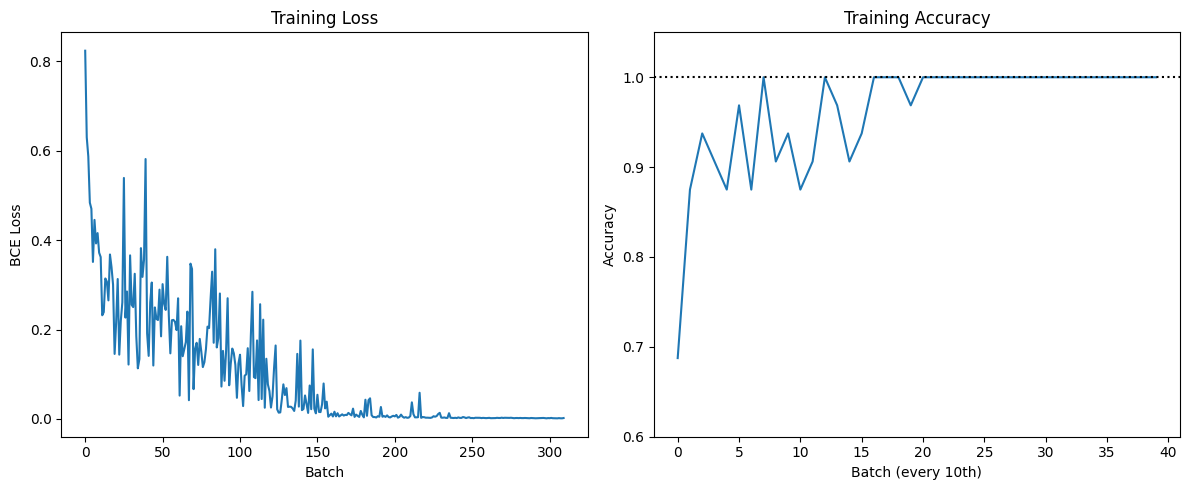

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple
import time


def create_synthetic_data(key, num_samples=1000, seq_len=15, vocab_size=20):
    """
    Create a synthetic dataset that should be easy for a transformer to learn:
    - If token ID 5 appears in the first 3 positions -> label = 1
    - Otherwise -> label = 0
    """
    subkey1, subkey2 = jr.split(key)
    
    # Create random sequences
    sequences = jr.randint(subkey1, (num_samples, seq_len), 0, vocab_size)
    
    # Create labels: 1 if token 5 appears in first 3 positions
    has_token_5 = (sequences[:, :3] == 5).any(axis=1)
    labels = has_token_5.astype(jnp.float32)
    
    # Ensure roughly 50/50 split of positive and negative examples
    pos_count = labels.sum()
    neg_count = num_samples - pos_count
    
    if pos_count < num_samples // 2:
        # Need more positive examples
        needed = num_samples // 2 - pos_count
        neg_indices = jnp.where(~has_token_5)[0]
        selected = neg_indices[:int(needed)]
        
        # Add token 5 to first position of selected examples
        sequences = sequences.at[selected, 0].set(5)
        labels = labels.at[selected].set(1.0)
    elif neg_count < num_samples // 2:
        # Need more negative examples
        needed = num_samples // 2 - neg_count
        pos_indices = jnp.where(has_token_5)[0]
        selected = pos_indices[:int(needed)]
        
        # Remove token 5 from first 3 positions
        for i in selected:
            for j in range(3):
                if sequences[i, j] == 5:
                    sequences = sequences.at[i, j].set(0)
        labels = labels.at[selected].set(0.0)
    
    # Shuffle the data
    shuffle_key = jr.split(subkey2)[0]
    perm = jr.permutation(shuffle_key, num_samples)
    sequences = sequences[perm]
    labels = labels[perm]
    
    return sequences, labels

@eqx.filter_jit
def compute_loss(model, x_batch, y_batch, key=None):
    """Compute BCE loss for a batch"""
    # Call model on each sequence in the batch
    logits = jax.vmap(lambda tokens: model(tokens, enable_dropout=False, key=key))(x_batch)
    
    # Extract the first token logit for classification
    logits = logits[:, 0]  # Use this if classifying based on first token
    
    # Sigmoid cross-entropy loss
    probas = jax.nn.sigmoid(logits)
    # Add small epsilon to prevent log of 0
    epsilon = 1e-6
    probas = jnp.clip(probas, epsilon, 1.0 - epsilon)
    bce_loss = -y_batch * jnp.log(probas) - (1 - y_batch) * jnp.log(1 - probas)
    return bce_loss.mean()

@eqx.filter_jit
def compute_accuracy(model, x_batch, y_batch, key=None):
    """Compute accuracy for a batch"""
    logits = jax.vmap(lambda tokens: model(tokens, enable_dropout=False, key=key))(x_batch)
    probas = jax.nn.sigmoid(logits[:, 0])
    predictions = (probas > 0.5).astype(jnp.float32)
    return (predictions == y_batch).mean()

@eqx.filter_jit
def train_step(model, opt_state, x_batch, y_batch, optimizer, key=None):
    """Single training step"""
    # Split model into trainable and static parts
    trainable, static = eqx.partition(model, eqx.is_inexact_array)
    
    # Define loss function for computing gradients
    def loss_fn(trainable_params):
        # Combine trainable and static parameters
        model_combined = eqx.combine(trainable_params, static)
        # Compute loss
        return compute_loss(model_combined, x_batch, y_batch, key)
    
    # Compute gradients and loss
    loss, grads = jax.value_and_grad(loss_fn)(trainable)
    
    # Clip gradients to prevent NaN issues
    grads = jax.tree.map(
        lambda g: jnp.clip(g, -1.0, 1.0),
        grads
    )
    
    # Update parameters
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_model = eqx.apply_updates(model, updates)
    
    return new_model, new_opt_state, loss

def main():
    # Set random seed for reproducibility
    key = jr.PRNGKey(42)
    key, data_key, model_key = jr.split(key, 3)
    
    # Create synthetic data
    print("Creating synthetic data...")
    num_samples = 1000
    seq_len = 15
    vocab_size = 20
    train_x, train_y = create_synthetic_data(data_key, num_samples, seq_len, vocab_size)
    
    # Print data statistics
    print(f"Data created: {num_samples} samples")
    print(f"Positive examples: {int(train_y.sum())}")
    print(f"Negative examples: {int(num_samples - train_y.sum())}")
    
    # Create model with simplified architecture
    print("Creating transformer model...")
    model = TransformerModel(
        vocab_size=vocab_size,
        embed_dim=64,           # Smaller embedding size
        intermediate_size=128,  # Smaller hidden size
        num_layers=1,           # Start with 2 layers
        num_heads=4,            # Reasonable number of attention heads
        dropout_rate=0.1,       # Add some regularization
        attention_dropout_rate=0.1,
        key=model_key
    )
    
    # Create optimizer
    learning_rate = 1e-3
    optimizer = optax.adam(learning_rate)
    
    # Initialize optimizer state (only on trainable params)
    trainable, _ = eqx.partition(model, eqx.is_inexact_array)
    opt_state = optimizer.init(trainable)
    
    # Training parameters
    batch_size = 32
    num_epochs = 10
    steps_per_epoch = num_samples // batch_size
    
    # Track metrics
    loss_history = []
    accuracy_history = []
    
    # Training loop
    print("Starting training...")
    print("Epoch | Batch | Loss       | Accuracy")
    print("------|-------|------------|----------")
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Shuffle data for each epoch
        epoch_key = jr.fold_in(key, epoch)
        perm = jr.permutation(epoch_key, num_samples)
        x_shuffled = train_x[perm]
        y_shuffled = train_y[perm]
        
        # Batch training
        for i in range(steps_per_epoch):
            # Extract batch
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            x_batch = x_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Generate key for this step
            step_key = jr.fold_in(epoch_key, i)
            
            # Train on batch
            model, opt_state, loss = train_step(
                model, opt_state, x_batch, y_batch, optimizer, key=step_key
            )
            
            # Track loss
            loss_value = float(loss)
            loss_history.append(loss_value)
            
            # Print progress every 10 batches
            if i % 10 == 0:
                # Compute accuracy on this batch
                accuracy = float(compute_accuracy(model, x_batch, y_batch))
                accuracy_history.append(accuracy)
                
                # Print formatted output
                print(f"{epoch:4d} | {i:5d} | {loss_value:.8f} | {accuracy:.8f}")
    
    elapsed_time = time.time() - start_time
    print(f"\nTraining completed in {elapsed_time:.2f} seconds")
    
    # Final evaluation on all data
    final_accuracy = float(compute_accuracy(model, train_x, train_y))
    print(f"Final accuracy: {final_accuracy:.4f}")
    
    # Plot loss and accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('BCE Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history)
    plt.title('Training Accuracy')
    plt.xlabel('Batch (every 10th)')
    plt.ylabel('Accuracy')
    plt.ylim(0.6, 1.05)
    plt.axhline(y=1, linestyle=":", color="black")  # You can change color as needed
    
    plt.tight_layout()
    plt.savefig('transformer_test_results.png')
    print("Results plotted and saved to 'transformer_test_results.png'")

main()

Creating synthetic data...
Data created: 1000 samples
Positive examples: 500
Negative examples: 500
Starting training...
Epoch | Batch | Loss       | Accuracy
------|-------|------------|----------
   0 |     0 | 0.73869526 | 0.62500000
  Embedding norm: 1.0000, Relation norm: 1.0000
   0 |    10 | 0.42065781 | 0.90625000
   0 |    20 | 0.39748910 | 0.93750000
   0 |    30 | 0.41872573 | 0.90625000
   1 |     0 | 0.43873471 | 0.87500000
  Embedding norm: 1.0000, Relation norm: 1.0000
   1 |    10 | 0.34664881 | 0.96875000
   1 |    20 | 0.43481320 | 0.87500000
   1 |    30 | 0.31614554 | 1.00000000
   2 |     0 | 0.37688518 | 0.93750000
  Embedding norm: 1.0000, Relation norm: 1.0000
   2 |    10 | 0.44078034 | 0.87500000
   2 |    20 | 0.46840197 | 0.84375000
   2 |    30 | 0.47017786 | 0.84375000
   3 |     0 | 0.34476233 | 0.96875000
  Embedding norm: 1.0000, Relation norm: 1.0000
   3 |    10 | 0.43783924 | 0.87500000
   3 |    20 | 0.43662471 | 0.87500000
   3 |    30 | 0.50034094

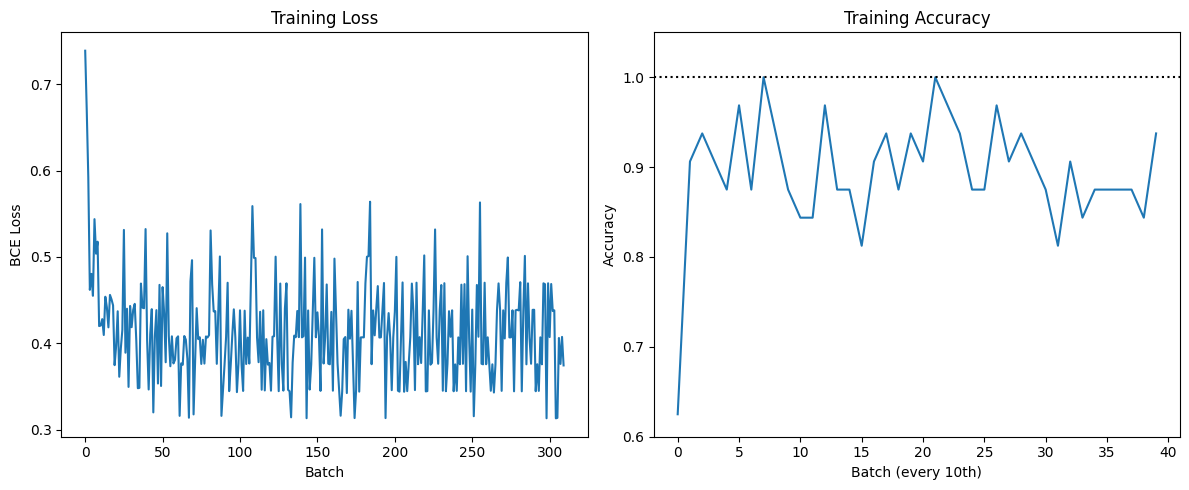

In [16]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt
from typing import NamedTuple
import time

class RAdamState(NamedTuple):
    count: jnp.ndarray
    m: jnp.ndarray
    v: jnp.ndarray

def init_radam(params: jnp.ndarray,
               lr: float = 1e-3,
               b1: float = 0.9,
               b2: float = 0.999,
               eps: float = 1e-8):
    """Initialize Riemannian Adam state for quaternionic parameters."""
    zero = jnp.zeros_like(params)
    return RAdamState(count=jnp.array(0), m=zero, v=zero), (lr, b1, b2, eps)

def radam_update(p: jnp.ndarray,
                 g: jnp.ndarray,
                 state: RAdamState,
                 hyper: tuple) -> tuple[jnp.ndarray, RAdamState]:
    """
    Riemannian Adam optimizer for unit quaternions (S^3) using the exponential map.
    Inputs:
        p:     (..., 4) unit quaternions (points on S^3)
        g:     (..., 4) Euclidean gradient
        state: RAdamState with moments and timestep
        hyper: Tuple (lr, b1, b2, eps)
    Output:
        Updated p on S^3 and updated optimizer state
    """
    lr, b1, b2, eps = hyper
    actual_lr = lr * 0.1

    # Safety checks
    p = jnp.where(jnp.isnan(p), jnp.ones_like(p) * 0.01, p)
    g = jnp.where(jnp.isnan(g), jnp.zeros_like(g), g)
    g = jnp.clip(g, -1.0, 1.0)

    # Project gradient onto tangent space of S^3
    inner = jnp.sum(p * g, axis=-1, keepdims=True)
    g_tan = g - p * inner
    g_tan = jnp.clip(g_tan, -0.5, 0.5)

    # Update biased moments
    count = state.count + 1
    m = b1 * state.m + (1 - b1) * g_tan
    v = b2 * state.v + (1 - b2) * (g_tan ** 2)

    # Bias correction
    b1_power = jnp.clip(b1**count, 1e-10, 1.0 - 1e-10)
    b2_power = jnp.clip(b2**count, 1e-10, 1.0 - 1e-10)

    m_hat = m / (1.0 - b1_power)
    v_hat = v / (1.0 - b2_power)

    m_hat = jnp.clip(m_hat, -1.0, 1.0)
    v_hat = jnp.clip(v_hat, 1e-7, 1.0)

    # Compute Riemannian update direction
    u = m_hat / (jnp.sqrt(v_hat) + eps * 10.0)
    u = jnp.clip(u, -0.5, 0.5)

    # Exponential map: exp_p(-lr * u)
    step = -actual_lr * u
    norm = jnp.linalg.norm(step, axis=-1, keepdims=True)

    # Handle small norm cases with Taylor expansion
    small = norm < 1e-7
    sin_over_norm = jnp.where(small,
                              1.0 - norm**2 / 6.0,
                              jnp.sin(norm) / norm)

    p_new = jnp.cos(norm) * p + sin_over_norm * step

    # Final safety: renormalize to S^3 and fix NaNs
    norm_p_new = jnp.linalg.norm(p_new, axis=-1, keepdims=True)
    p_new = p_new / jnp.maximum(norm_p_new, 1e-5)
    p_new = jnp.where(jnp.isnan(p_new), p, p_new)

    return p_new, RAdamState(count=count, m=m, v=v)

def create_synthetic_data(key, num_samples=1000, seq_len=15, vocab_size=20):
    """Create a synthetic dataset that should be easy to learn."""
    subkey1, subkey2 = jr.split(key)
    
    # Create random sequences
    sequences = jr.randint(subkey1, (num_samples, seq_len), 0, vocab_size)
    
    # Create labels: 1 if token 5 appears in first 3 positions
    has_token_5 = (sequences[:, :3] == 5).any(axis=1)
    labels = has_token_5.astype(jnp.float32)
    
    # Ensure 50/50 split of positive and negative examples
    pos_count = labels.sum()
    neg_count = num_samples - pos_count
    
    if pos_count < num_samples // 2:
        # Add more positive examples
        needed = num_samples // 2 - pos_count
        neg_indices = jnp.where(~has_token_5)[0]
        selected = neg_indices[:int(needed)]
        sequences = sequences.at[selected, 0].set(5)
        labels = labels.at[selected].set(1.0)
    elif neg_count < num_samples // 2:
        # Add more negative examples
        needed = num_samples // 2 - neg_count
        pos_indices = jnp.where(has_token_5)[0]
        selected = pos_indices[:int(needed)]
        for i in selected:
            for j in range(3):
                if sequences[i, j] == 5:
                    sequences = sequences.at[i, j].set(0)
        labels = labels.at[selected].set(0.0)
    
    # Shuffle the data
    shuffle_key = jr.split(subkey2)[0]
    perm = jr.permutation(shuffle_key, num_samples)
    sequences = sequences[perm]
    labels = labels[perm]
    
    return sequences, labels

@eqx.filter_jit
def compute_loss(model, x_batch, y_batch):
    """Compute BCE loss for a batch."""
    logits = jax.vmap(model)(x_batch)
    
    # Sigmoid cross-entropy loss with safety
    probas = jax.nn.sigmoid(logits)
    epsilon = 1e-6
    probas = jnp.clip(probas, epsilon, 1.0 - epsilon)
    bce_loss = -y_batch * jnp.log(probas) - (1 - y_batch) * jnp.log(1 - probas)
    return jnp.mean(bce_loss)

@eqx.filter_jit
def compute_accuracy(model, x_batch, y_batch):
    """Compute accuracy for a batch."""
    logits = jax.vmap(model)(x_batch)
    probas = jax.nn.sigmoid(logits)
    predictions = (probas > 0.5).astype(jnp.float32)
    return jnp.mean(jnp.equal(predictions, y_batch))

@eqx.filter_jit
def train_step(model, euclid_state, emb_state, rel_state, x_batch, y_batch, euclid_opt, emb_hyper, rel_hyper):
    """Single training step with quaternionic optimization."""
    # Compute gradients
    loss, grads = eqx.filter_value_and_grad(lambda m: compute_loss(m, x_batch, y_batch))(model)
    
    # Clean gradients
    grads_safe = jax.tree.map(
        lambda g: jnp.where(jnp.isnan(g) | ~jnp.isfinite(g), 
                          jnp.zeros_like(g), 
                          jnp.clip(g, -0.1, 0.1)) if hasattr(g, 'shape') and g.shape != () else g,
        grads
    )
    
    # 1. Standard Adam update for all parameters
    updates, euclid_state_new = euclid_opt.update(grads_safe, euclid_state, model)
    model_updated = optax.apply_updates(model, updates)
    
    # 2. Riemannian Adam update for embeddings
    new_embs, emb_state_new = radam_update(
        model_updated.embed.embeddings,
        grads_safe.embed.embeddings,
        emb_state,
        emb_hyper
    )
    model_with_embs = eqx.tree_at(lambda m: m.embed.embeddings, model_updated, new_embs)
    
    # 3. Riemannian Adam update for attention relations
    new_rels, rel_state_new = radam_update(
        model_with_embs.att.relations,
        grads_safe.att.relations,
        rel_state,
        rel_hyper
    )
    model_final = eqx.tree_at(lambda m: m.att.relations, model_with_embs, new_rels)
    
    return model_final, euclid_state_new, emb_state_new, rel_state_new, loss

def main(model):
    """End-to-end test for KGTransformer with Riemannian optimization."""
    # Set random seed for reproducibility
    key = jr.PRNGKey(42)
    key, data_key = jr.split(key)
    
    # Create synthetic data
    print("Creating synthetic data...")
    num_samples = 1000
    seq_len = 15
    vocab_size = 20
    train_x, train_y = create_synthetic_data(data_key, num_samples, seq_len, vocab_size)
    
    # Print data statistics
    print(f"Data created: {num_samples} samples")
    print(f"Positive examples: {int(train_y.sum())}")
    print(f"Negative examples: {int(num_samples - train_y.sum())}")
    
    # Initialize optimizers
    euclid_opt = optax.adam(5e-4)  # Lower learning rate for stability
    euclid_state = euclid_opt.init(model)
    
    # Initialize Riemannian optimizers for quaternion parameters
    emb_state, emb_hyper = init_radam(model.embed.embeddings, lr=1e-3)
    rel_state, rel_hyper = init_radam(model.att.relations, lr=1e-3)
    
    # Training parameters
    batch_size = 32
    num_epochs = 10
    steps_per_epoch = num_samples // batch_size
    
    # Track metrics
    loss_history = []
    accuracy_history = []
    
    # Training loop
    print("Starting training...")
    print("Epoch | Batch | Loss       | Accuracy")
    print("------|-------|------------|----------")
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Shuffle data for each epoch
        epoch_key = jr.fold_in(key, epoch)
        perm = jr.permutation(epoch_key, num_samples)
        x_shuffled = train_x[perm]
        y_shuffled = train_y[perm]
        
        # Batch training
        for i in range(steps_per_epoch):
            # Extract batch
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            x_batch = x_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Apply training step with quaternionic optimization
            model, euclid_state, emb_state, rel_state, loss = train_step(
                model, euclid_state, emb_state, rel_state, 
                x_batch, y_batch, euclid_opt, emb_hyper, rel_hyper
            )
            
            # Track loss
            loss_value = float(loss)
            loss_history.append(loss_value)
            
            # Print progress every 10 batches
            if i % 10 == 0:
                # Compute accuracy on this batch
                accuracy = float(compute_accuracy(model, x_batch, y_batch))
                accuracy_history.append(accuracy)
                
                # Print formatted output
                print(f"{epoch:4d} | {i:5d} | {loss_value:.8f} | {accuracy:.8f}")
                
                # Monitor quaternion norms every 50 batches
                if i % 50 == 0:
                    emb_norm = float(jnp.mean(jnp.linalg.norm(model.embed.embeddings, axis=-1)))
                    rel_norm = float(jnp.mean(jnp.linalg.norm(model.att.relations, axis=-1)))
                    print(f"  Embedding norm: {emb_norm:.4f}, Relation norm: {rel_norm:.4f}")
    
    elapsed_time = time.time() - start_time
    print(f"\nTraining completed in {elapsed_time:.2f} seconds")
    
    # Final evaluation on all data
    final_accuracy = float(compute_accuracy(model, train_x, train_y))
    print(f"Final accuracy: {final_accuracy:.4f}")
    
    # Plot loss and accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('BCE Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history)
    plt.title('Training Accuracy')
    plt.xlabel('Batch (every 10th)')
    plt.ylabel('Accuracy')

    plt.ylim(0.6, 1.05)
    plt.axhline(y=1, linestyle=":", color="black")  # You can change color as needed
    
    plt.tight_layout()
    plt.savefig('kg_transformer_test_results_rmgd.png')
    print("Results plotted and saved to 'kg_transformer_test_results.png'")
    
    return model, loss_history, accuracy_history

# Initialize KGTransformer model
key = jr.PRNGKey(123)
model = KGTransformer(
    d=64,                  # Embedding dimension
    num_entities=20,       # Vocabulary size
    num_heads=4,           # Attention heads
    max_len=15,            # Maximum sequence length
    key=key
)

# Run the test
trained_model, loss_history, accuracy_history = main(model)